In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00


In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Time-series / statsmodels
from statsmodels.tsa.arima.model import ARIMA

# XGBoost & CatBoost
import xgboost as xgb
from catboost import CatBoostRegressor

# LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# For reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---------------------------
# Config / Change here
# ---------------------------
DATA_PATH = '/content/dairy_dataset.csv'   # fallback path (exists in your environment)
PRODUCTS = ['Ice Cream', 'Cheese', 'Buttermilk']  # chosen items (change if you want others)
DATE_COL = 'Date'
PRODUCT_COL = 'Product Name'
QUANTITY_SOLD_COL = 'Quantity Sold (liters/kg)'
AGG_FREQ = 'D'  # 'D' = daily, 'W' = weekly, 'M' = monthly
TEST_SIZE = 0.2  # 0.2 -> 80/20 ; set 0.3 for 70/30
LAGS = [1,2,3,7,14]  # lag features (days)
LSTM_SEQ_LEN = 14  # number of time-steps for LSTM sequences
EPOCHS = 30
BATCH_SIZE = 16

In [ ]:
# 1) Load dataset (with fallback file-upload if not present)
# ---------------------------
def load_dataset(path=DATA_PATH):
    if os.path.exists(path):
        df = pd.read_csv(path)
        print(f"Loaded dataset from {path}")
    else:
        # if running in a notebook, user can upload files manually (not implemented here)
        raise FileNotFoundError(f"{path} not found. Upload your dataset to that path or change DATA_PATH.")
    return df

df = load_dataset()

# Quick cleaning: ensure Date column is datetime and Quantity sold is numeric
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce')
# If quantity sold column has commas or strings, convert safely
df[QUANTITY_SOLD_COL] = pd.to_numeric(df[QUANTITY_SOLD_COL], errors='coerce')

# Drop rows without date or quantity sold
df = df.dropna(subset=[DATE_COL, QUANTITY_SOLD_COL])
print("Dataset shape after cleaning:", df.shape)

# Ensure products exist
present_products = df[PRODUCT_COL].unique().tolist()
for p in PRODUCTS:
    if p not in present_products:
        print(f"Warning: Product '{p}' not found in dataset. Available sample products: {present_products[:8]}")


Loaded dataset from /content/dairy_dataset.csv
Dataset shape after cleaning: (4325, 23)


In [ ]:
# ---------------------------
# 2) Helper functions
# ---------------------------
def aggregate_sales_by_product(df, product_name, date_col=DATE_COL, qty_col=QUANTITY_SOLD_COL, freq=AGG_FREQ):
    """Aggregate sales to a time series (sum of quantities) at chosen frequency."""
    df_p = df[df[PRODUCT_COL] == product_name].copy()
    ts = df_p.groupby(date_col)[qty_col].sum().asfreq(freq, fill_value=0)
    ts = ts.rename(product_name)
    return ts

def create_lag_features(ts, lags=LAGS):
    """Create DataFrame with lag features from a pandas Series ts (indexed by date)."""
    df_lag = pd.DataFrame(ts).rename(columns={ts.name: 'y'})
    for lag in lags:
        df_lag[f'lag_{lag}'] = df_lag['y'].shift(lag)
    # rolling features
    df_lag['rolling_mean_7'] = df_lag['y'].shift(1).rolling(window=7, min_periods=1).mean()
    df_lag['rolling_std_7'] = df_lag['y'].shift(1).rolling(window=7, min_periods=1).std().fillna(0)
    df_lag = df_lag.dropna()
    return df_lag

def train_test_split_ts(df_features, test_size=TEST_SIZE):
    """Time-series train/test split (no shuffling)."""
    n = len(df_features)
    split_point = int(np.round(n * (1 - test_size)))
    train = df_features.iloc[:split_point]
    test = df_features.iloc[split_point:]
    return train, test

def evaluate_preds(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # ---- SMAPE (symmetric MAPE) ----
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape = np.mean(
        np.where(
            denominator == 0,
            0,
            np.abs(y_true - y_pred) / denominator
        )
    ) * 100

    return {'MAE': mae, 'RMSE': rmse, 'SMAPE': smape}


In [ ]:
# ---------------------------
# 3) Modeling functions
# ---------------------------
def run_arima(train_series, test_series, order=(1,1,1)):
    """Fit ARIMA on the train_series (p,d,q) and forecast len(test_series)."""
    model = ARIMA(train_series, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test_series))
    return forecast, model_fit

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=input_shape),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def prepare_lstm_data(series, seq_len=LSTM_SEQ_LEN, scaler=None):
    """Prepare X,y for LSTM from one-dimensional series (pandas Series)."""
    arr = series.values.reshape(-1,1)
    if scaler is None:
        scaler = MinMaxScaler()
        arr_scaled = scaler.fit_transform(arr)
    else:
        arr_scaled = scaler.transform(arr)
    X, y = [], []
    for i in range(seq_len, len(arr_scaled)):
        X.append(arr_scaled[i-seq_len:i, 0])
        y.append(arr_scaled[i, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y, scaler

def train_lstm_and_forecast(series, test_len, seq_len=LSTM_SEQ_LEN, epochs=EPOCHS, batch_size=BATCH_SIZE):
    """Train LSTM on full series and produce forecast for last test_len points by walk-forward predictions."""
    # Use MinMaxScaler on whole series
    scaler = MinMaxScaler()
    arr = series.values.reshape(-1,1)
    arr_scaled = scaler.fit_transform(arr)
    # train sequences for entire data except last test_len to simulate forecasting
    train_scaled = arr_scaled[:-test_len]
    X_train, y_train = [], []
    for i in range(seq_len, len(train_scaled)):
        X_train.append(train_scaled[i-seq_len:i, 0])
        y_train.append(train_scaled[i, 0])
    X_train = np.array(X_train).reshape(-1, seq_len, 1)
    y_train = np.array(y_train)
    model = build_lstm_model((seq_len, 1))
    es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=0)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es])
    # Walk-forward forecasting
    history = arr_scaled.copy()
    preds = []
    for _ in range(test_len):
        x_input = history[-seq_len:].reshape(1, seq_len, 1)
        yhat = model.predict(x_input, verbose=0)[0,0]
        preds.append(yhat)
        history = np.vstack([history, [[yhat]]])
    # Inverse transform
    preds = scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
    return preds, model

def run_xgboost(train_df, test_df, feature_cols, target_col='y'):
    dtrain = xgb.DMatrix(train_df[feature_cols], label=train_df[target_col])
    dtest = xgb.DMatrix(test_df[feature_cols], label=test_df[target_col])
    params = {
        'objective': 'reg:squarederror',
        'seed': SEED,
        'eval_metric': 'rmse'
    }
    bst = xgb.train(params, dtrain, num_boost_round=200, verbose_eval=False)
    preds = bst.predict(dtest)
    return preds, bst

def run_catboost(train_df, test_df, feature_cols, target_col='y'):
    cat_features = [i for i,c in enumerate(feature_cols) if train_df[feature_cols[i]].dtype == 'object']
    model = CatBoostRegressor(iterations=500, learning_rate=0.05, verbose=False, random_seed=SEED)
    model.fit(train_df[feature_cols], train_df[target_col])
    preds = model.predict(test_df[feature_cols])
    return preds, model

def hybrid_arima_lstm(train_series, test_series, arima_order=(1,1,1), seq_len=LSTM_SEQ_LEN):
    """
    Simple hybrid:
    1) Fit ARIMA on train_series
    2) Forecast test_len steps with ARIMA -> arima_forecast
    3) Compute residuals on train (train - arima_in_sample_pred) and train LSTM on residual series
    4) Forecast residuals with LSTM for test_len
    5) final_forecast = arima_forecast + lstm_residual_forecast
    """
    # ARIMA fit and in-sample prediction
    arima_model = ARIMA(train_series, order=arima_order).fit()
    in_sample_pred = arima_model.predict(start=train_series.index[0], end=train_series.index[-1])
    residuals = train_series - in_sample_pred
    # Train LSTM on residuals
    # Prepare LSTM for residual series (we will use residuals as 1D series)
    # Fill NA if any
    residuals = residuals.fillna(0)
    res_preds, lstm_model = train_lstm_and_forecast(residuals, test_len=len(test_series), seq_len=seq_len)
    # ARIMA forecast
    arima_forecast = arima_model.forecast(steps=len(test_series))
    final = arima_forecast.values + res_preds
    return final, arima_model, lstm_model




Processing product: Ice Cream


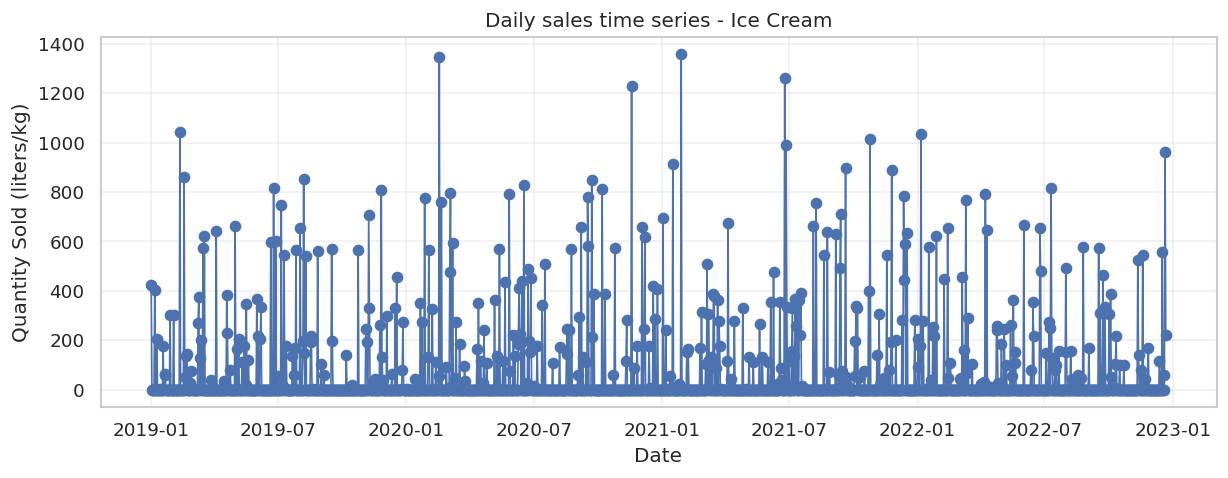

Lagged features shape: (1438, 8)
Train length: 1150 Test length: 288
Running ARIMA...


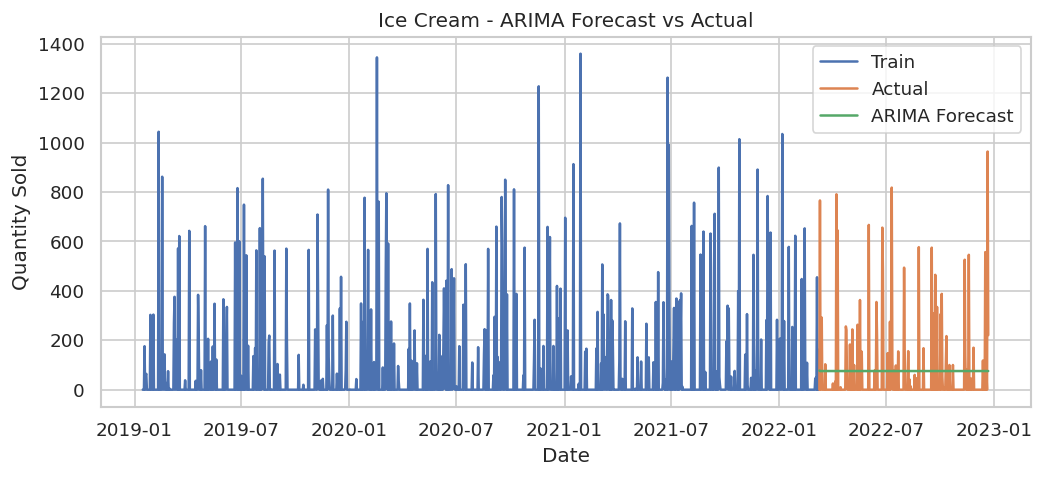

Running LSTM...


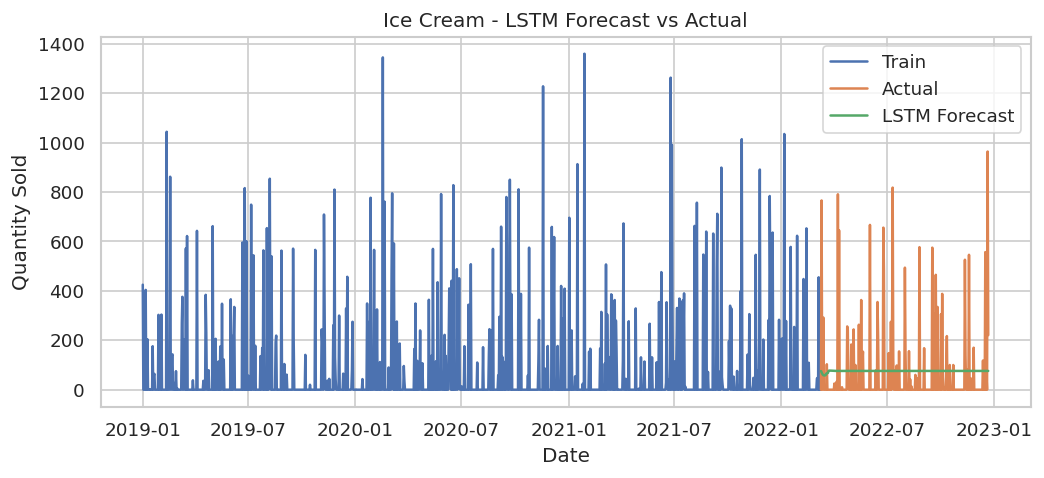

Running Hybrid ARIMA + LSTM...


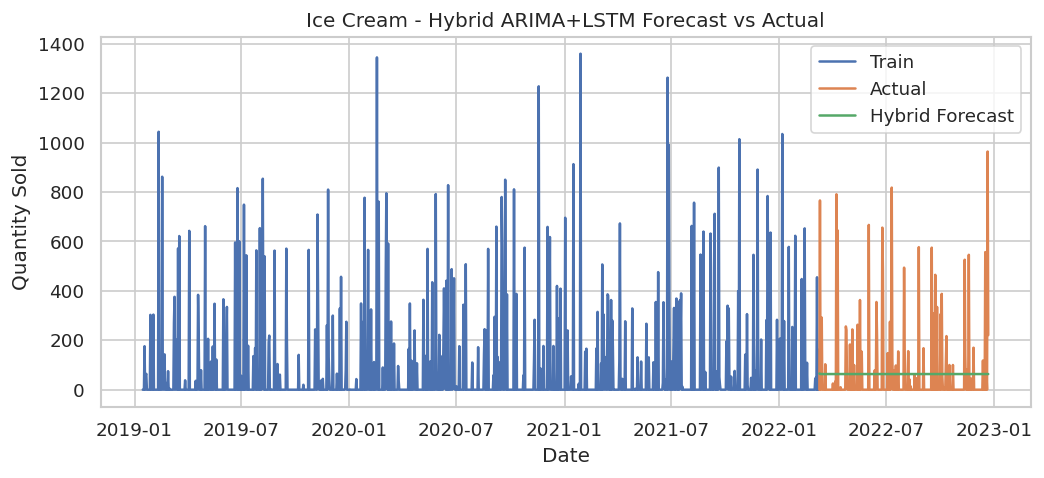

Running XGBoost...


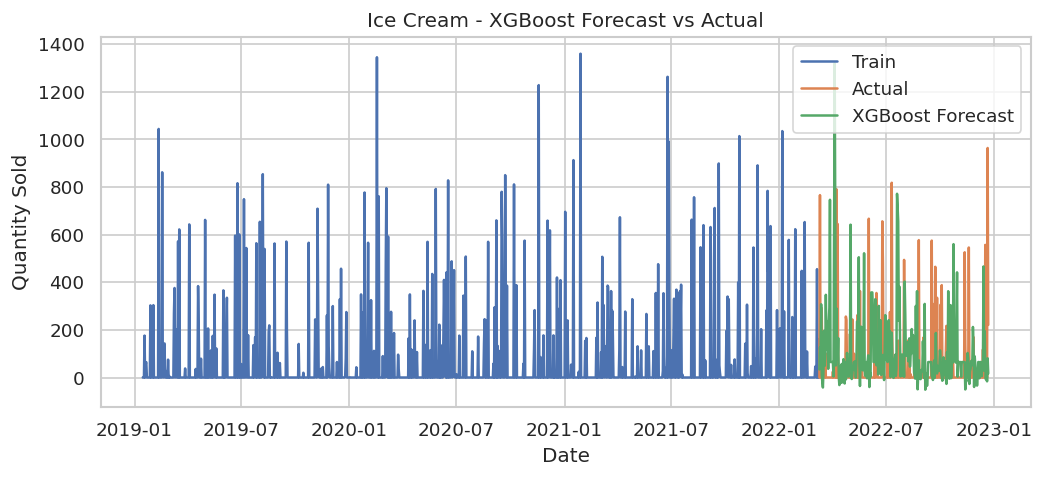

Running CatBoost...


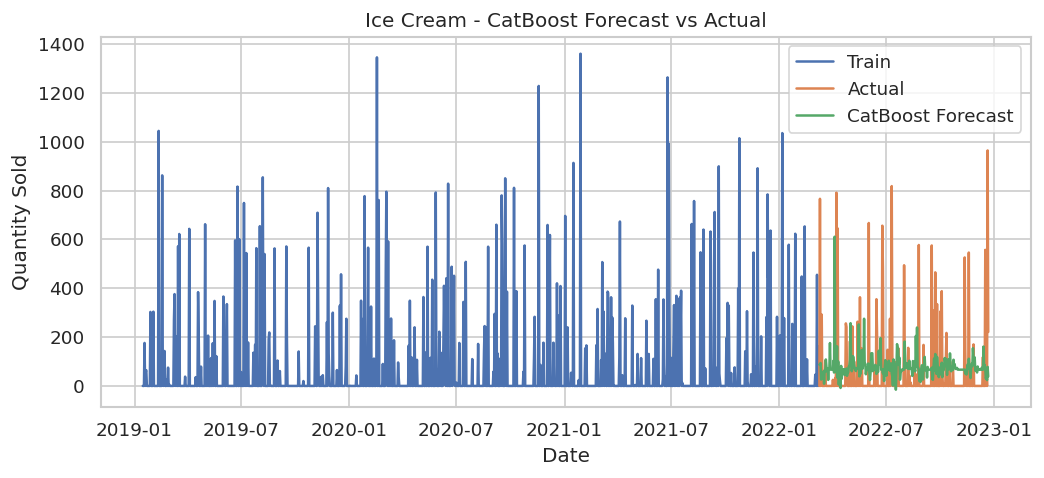


Model comparison for Ice Cream


Product              Model         MAE        RMSE       SMAPE
0  Ice Cream              ARIMA  104.271210  156.865724  175.326616
4  Ice Cream           CatBoost  108.204153  166.401121  177.177759
2  Ice Cream  Hybrid_ARIMA_LSTM   96.531736  156.116210  176.785768
1  Ice Cream               LSTM  104.331680  156.945123  175.394034
3  Ice Cream            XGBoost  143.065247  231.563462  182.147161



Processing product: Cheese


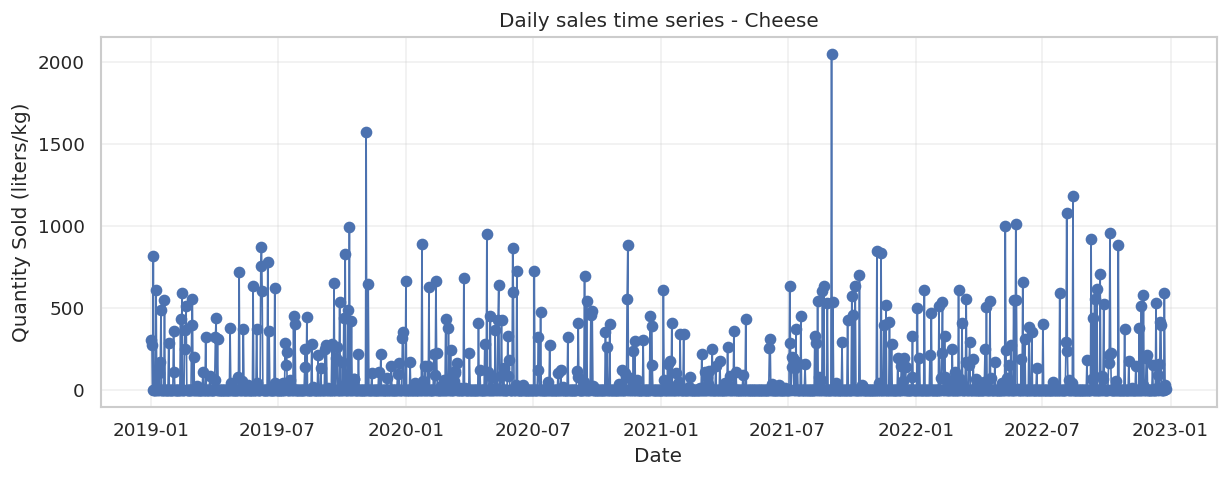

Lagged features shape: (1441, 8)
Train length: 1153 Test length: 288
Running ARIMA...


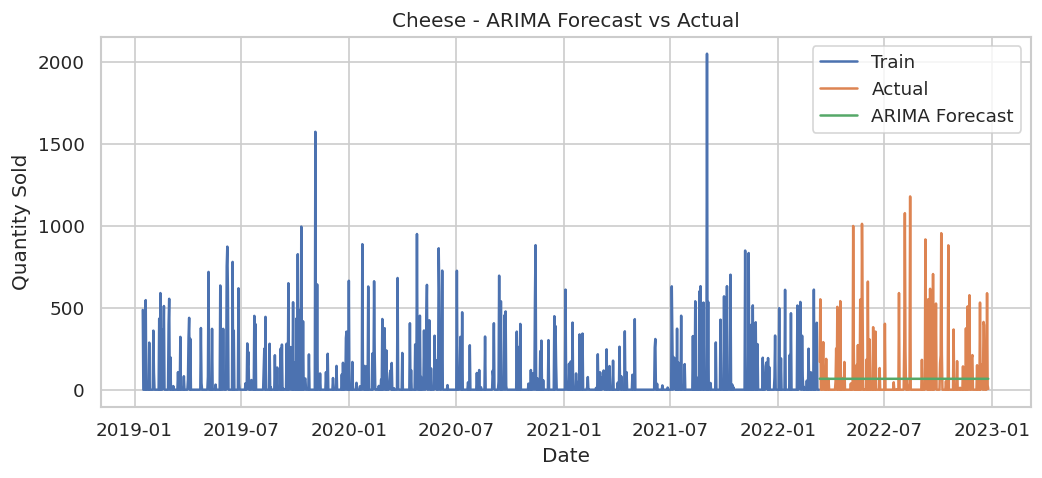

Running LSTM...


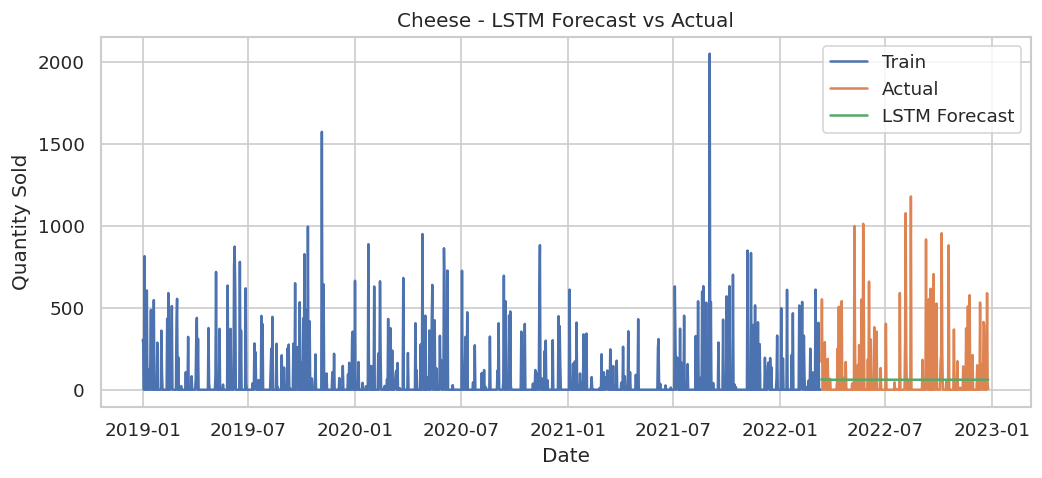

Running Hybrid ARIMA + LSTM...


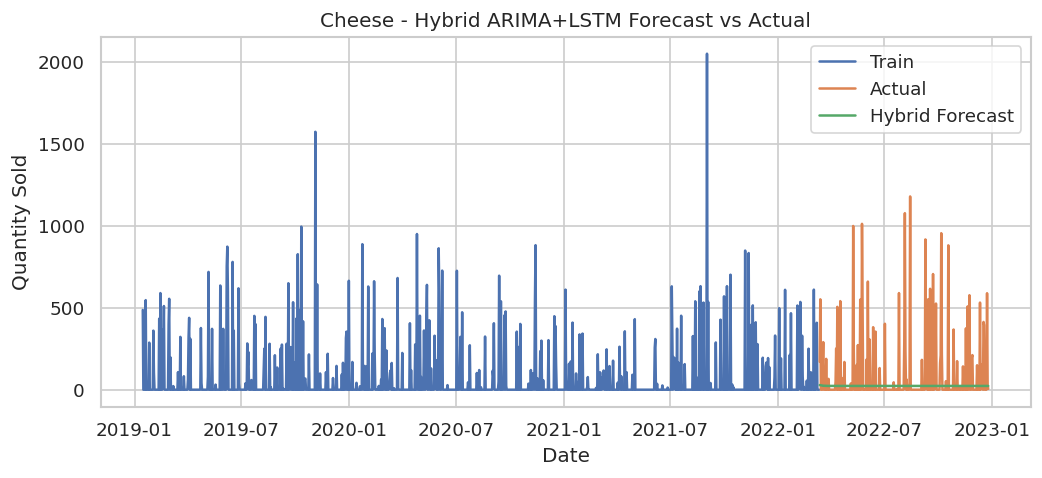

Running XGBoost...


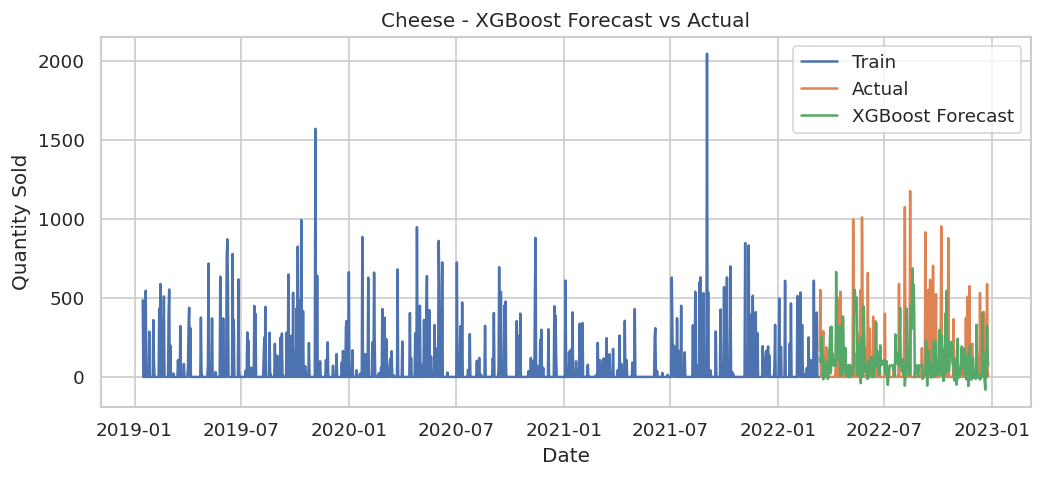

Running CatBoost...


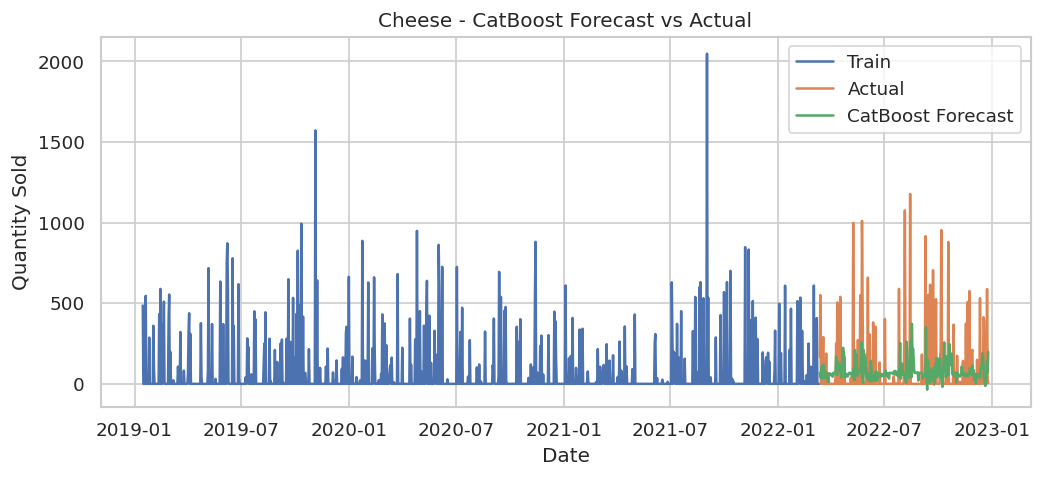


Model comparison for Cheese


Product              Model         MAE        RMSE       SMAPE
0  Cheese              ARIMA  120.463167  206.962465  177.604582
4  Cheese           CatBoost  130.698257  217.816905  178.068932
2  Cheese  Hybrid_ARIMA_LSTM   96.486224  215.153560  186.969424
1  Cheese               LSTM  117.223053  207.518872  178.409511
3  Cheese            XGBoost  162.380157  252.199218  182.522402



Processing product: Buttermilk


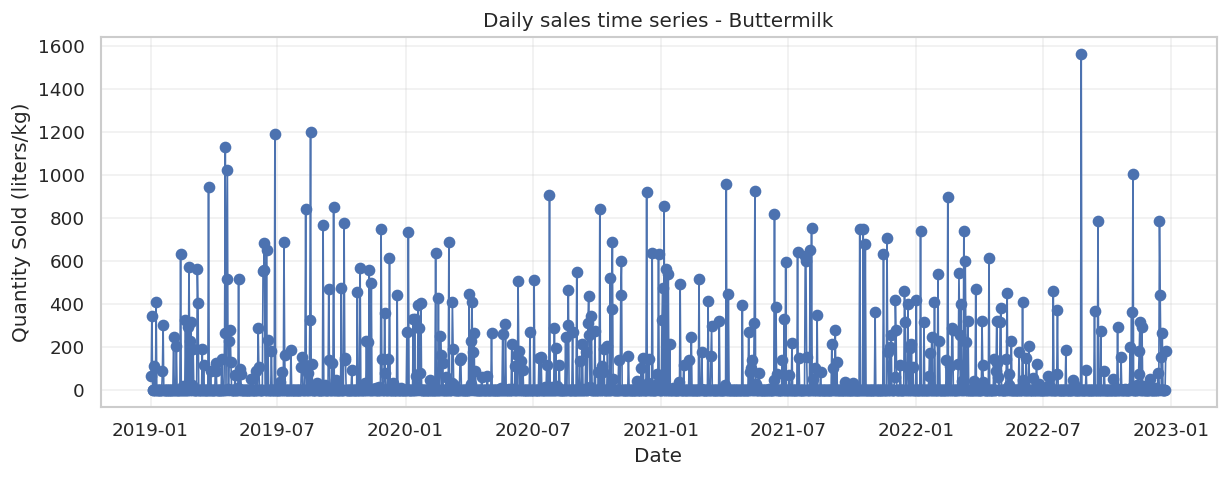

Lagged features shape: (1439, 8)
Train length: 1151 Test length: 288
Running ARIMA...


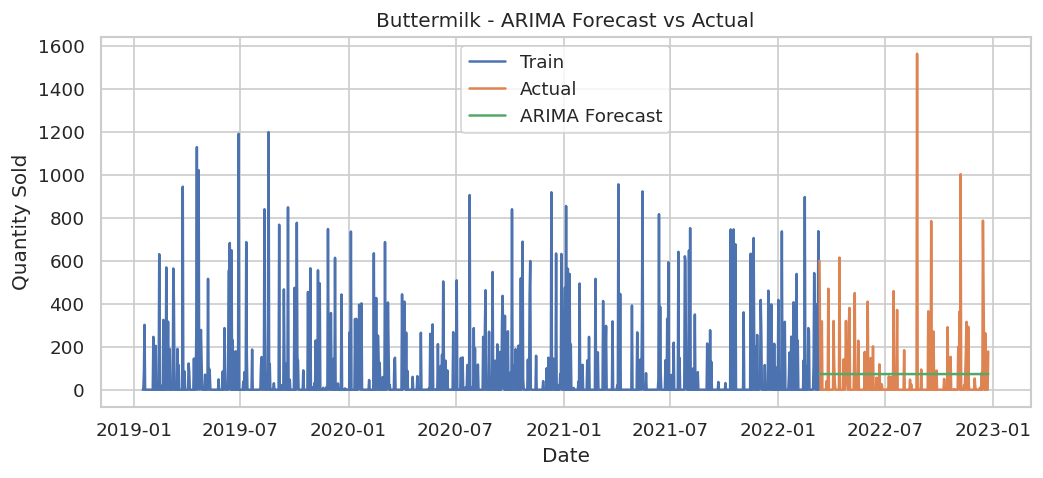

Running LSTM...


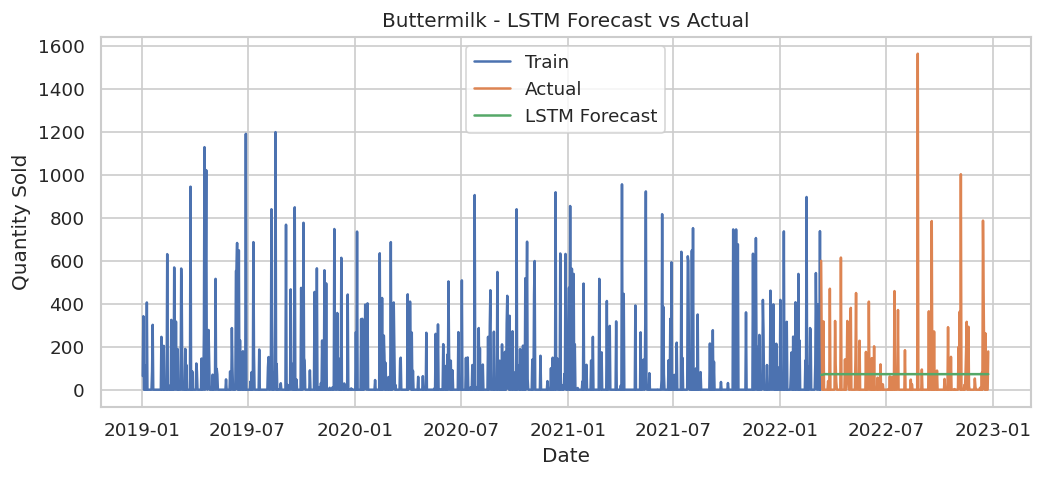

Running Hybrid ARIMA + LSTM...


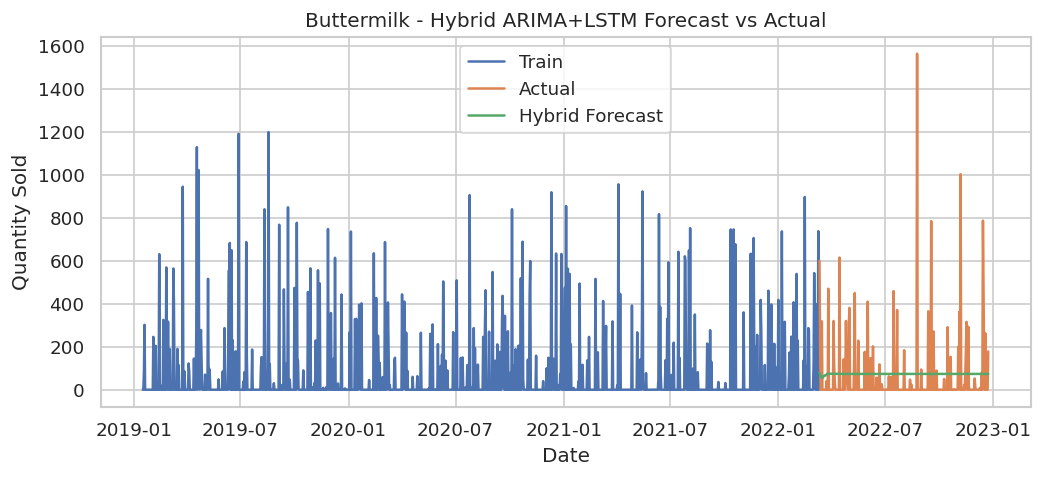

Running XGBoost...


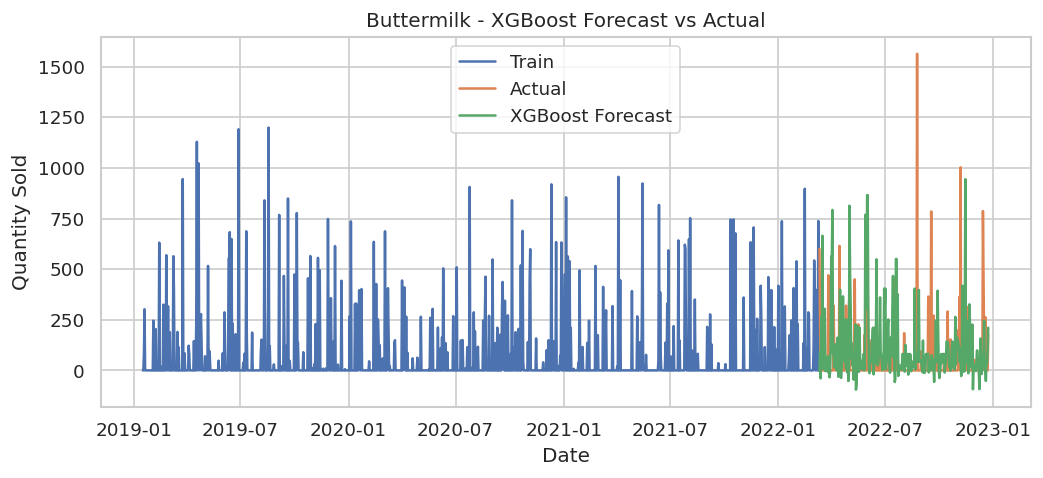

Running CatBoost...


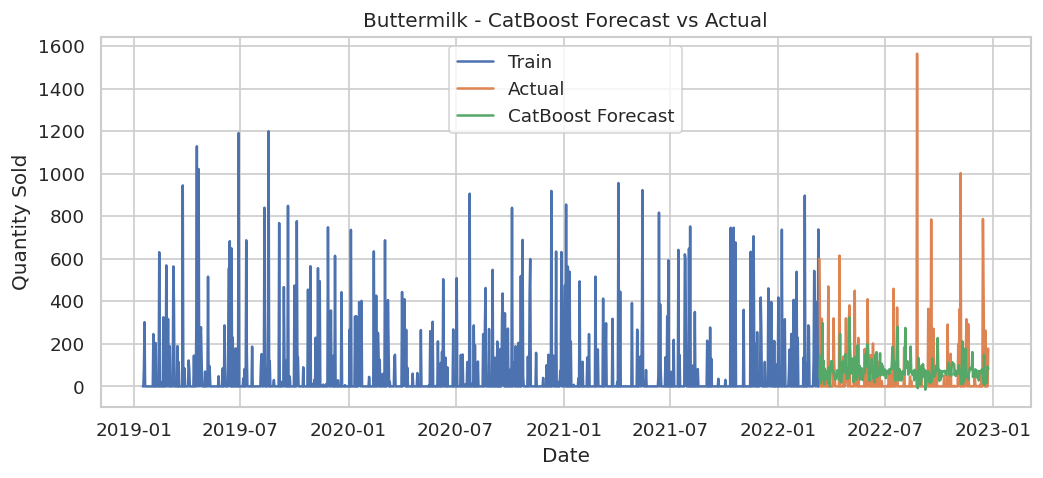


Model comparison for Buttermilk


Product              Model         MAE        RMSE       SMAPE
0  Buttermilk              ARIMA   98.803723  162.131320  175.265961
4  Buttermilk           CatBoost  102.186815  169.969138  176.022657
2  Buttermilk  Hybrid_ARIMA_LSTM   98.961357  162.110990  175.247401
1  Buttermilk               LSTM   98.497040  162.121392  175.314375
3  Buttermilk            XGBoost  140.854187  238.269182  183.161934

In [ ]:
# ---------------------------
# 4) Pipeline for each product
# ---------------------------
results = []   # store metrics per product per model
comparison_tables = {}

for product in PRODUCTS:
    print("\n\n====================")
    print("Processing product:", product)
    print("====================")
    # 4.1 Aggregate time series
    ts = aggregate_sales_by_product(df, product)
    if ts.sum() == 0:
        print(f"Warning: product '{product}' has zero total sales in aggregated series. Skipping.")
        continue

    # Fill missing dates (as already done by asfreq in aggregation) and plot
    plt.figure(figsize=(12,4))
    plt.plot(ts.index, ts.values, marker='o', linewidth=1)
    plt.title(f"Daily sales time series - {product}")
    plt.xlabel("Date")   # X axis = Date/time
    plt.ylabel("Quantity Sold (liters/kg)")  # Y axis = daily total quantity sold
    plt.grid(alpha=0.3)
    plt.show()

    # 4.2 create lag features dataframe (for ML)
    df_lag = create_lag_features(ts, LAGS)
    print("Lagged features shape:", df_lag.shape)

    # 4.3 train/test split
    train_df, test_df = train_test_split_ts(df_lag, test_size=TEST_SIZE)
    print("Train length:", len(train_df), "Test length:", len(test_df))

    # Feature columns for tree models
    feature_cols = [c for c in df_lag.columns if c != 'y']

    # ---------------- ARIMA ----------------
    print("Running ARIMA...")
    # Use simple auto-order or (1,1,1). For research, explain you can use AIC-based selection.
    try:
        arima_forecast, arima_model = run_arima(train_df['y'], test_df['y'], order=(1,1,1))
    except Exception as e:
        print("ARIMA failed with error:", e, "Trying (2,1,2)...")
        arima_forecast, arima_model = run_arima(train_df['y'], test_df['y'], order=(2,1,2))
    arima_metrics = evaluate_preds(test_df['y'].values, arima_forecast.values)
    results.append({'Product': product, 'Model': 'ARIMA', **arima_metrics})

    # Plot ARIMA results
    plt.figure(figsize=(10,4))
    plt.plot(train_df.index, train_df['y'], label='Train')
    plt.plot(test_df.index, test_df['y'], label='Actual')
    plt.plot(test_df.index, arima_forecast.values, label='ARIMA Forecast')
    plt.title(f"{product} - ARIMA Forecast vs Actual")
    plt.xlabel("Date")
    plt.ylabel("Quantity Sold")
    plt.legend()
    plt.show()

    # ---------------- LSTM ----------------
    print("Running LSTM...")
    # train on full series but simulate forecasting last test_len values in function
    lstm_preds, lstm_model = train_lstm_and_forecast(ts, test_len=len(test_df), seq_len=LSTM_SEQ_LEN, epochs=EPOCHS)
    lstm_metrics = evaluate_preds(test_df['y'].values, lstm_preds)
    results.append({'Product': product, 'Model': 'LSTM', **lstm_metrics})

    plt.figure(figsize=(10,4))
    plt.plot(ts.index[:-len(test_df)], ts.values[:-len(test_df)], label='Train')
    plt.plot(test_df.index, test_df['y'].values, label='Actual')
    plt.plot(test_df.index, lstm_preds, label='LSTM Forecast')
    plt.title(f"{product} - LSTM Forecast vs Actual")
    plt.xlabel("Date")
    plt.ylabel("Quantity Sold")
    plt.legend()
    plt.show()

    # ---------------- Hybrid ARIMA + LSTM ----------------
    print("Running Hybrid ARIMA + LSTM...")
    hybrid_preds, _, _ = hybrid_arima_lstm(train_df['y'], test_df['y'], arima_order=(1,1,1), seq_len=LSTM_SEQ_LEN)
    hybrid_metrics = evaluate_preds(test_df['y'].values, hybrid_preds)
    results.append({'Product': product, 'Model': 'Hybrid_ARIMA_LSTM', **hybrid_metrics})

    plt.figure(figsize=(10,4))
    plt.plot(train_df.index, train_df['y'], label='Train')
    plt.plot(test_df.index, test_df['y'], label='Actual')
    plt.plot(test_df.index, hybrid_preds, label='Hybrid Forecast')
    plt.title(f"{product} - Hybrid ARIMA+LSTM Forecast vs Actual")
    plt.xlabel("Date")
    plt.ylabel("Quantity Sold")
    plt.legend()
    plt.show()

    # ---------------- XGBoost ----------------
    print("Running XGBoost...")
    # Train XGBoost on train_df features
    xgb_preds, xgb_model = run_xgboost(train_df, test_df, feature_cols, target_col='y')
    xgb_metrics = evaluate_preds(test_df['y'].values, xgb_preds)
    results.append({'Product': product, 'Model': 'XGBoost', **xgb_metrics})

    plt.figure(figsize=(10,4))
    plt.plot(train_df.index, train_df['y'], label='Train')
    plt.plot(test_df.index, test_df['y'], label='Actual')
    plt.plot(test_df.index, xgb_preds, label='XGBoost Forecast')
    plt.title(f"{product} - XGBoost Forecast vs Actual")
    plt.xlabel("Date")
    plt.ylabel("Quantity Sold")
    plt.legend()
    plt.show()

    # ---------------- CatBoost ----------------
    print("Running CatBoost...")
    try:
        cat_preds, cat_model = run_catboost(train_df, test_df, feature_cols, target_col='y')
        cat_metrics = evaluate_preds(test_df['y'].values, cat_preds)
        results.append({'Product': product, 'Model': 'CatBoost', **cat_metrics})

        plt.figure(figsize=(10,4))
        plt.plot(train_df.index, train_df['y'], label='Train')
        plt.plot(test_df.index, test_df['y'], label='Actual')
        plt.plot(test_df.index, cat_preds, label='CatBoost Forecast')
        plt.title(f"{product} - CatBoost Forecast vs Actual")
        plt.xlabel("Date")
        plt.ylabel("Quantity Sold")
        plt.legend()
        plt.show()
    except Exception as e:
        print("CatBoost error (maybe not installed):", e)

    # gather comparison table for this product
    comp_df = pd.DataFrame([r for r in results if r['Product']==product]).sort_values('Model')
    comparison_tables[product] = comp_df
    print("\nModel comparison for", product)
    display(comp_df)



Overall results:


Product              Model         MAE        RMSE       SMAPE
0    Ice Cream              ARIMA  104.271210  156.865724  175.326616
1    Ice Cream               LSTM  104.331680  156.945123  175.394034
2    Ice Cream  Hybrid_ARIMA_LSTM   96.531736  156.116210  176.785768
3    Ice Cream            XGBoost  143.065247  231.563462  182.147161
4    Ice Cream           CatBoost  108.204153  166.401121  177.177759
5       Cheese              ARIMA  120.463167  206.962465  177.604582
6       Cheese               LSTM  117.223053  207.518872  178.409511
7       Cheese  Hybrid_ARIMA_LSTM   96.486224  215.153560  186.969424
8       Cheese            XGBoost  162.380157  252.199218  182.522402
9       Cheese           CatBoost  130.698257  217.816905  178.068932
10  Buttermilk              ARIMA   98.803723  162.131320  175.265961
11  Buttermilk               LSTM   98.497040  162.121392  175.314375
12  Buttermilk  Hybrid_ARIMA_LSTM   98.961357  162.110990  175.247401
13  Buttermilk            XGBoost  140.854187  238.269182  183.161934
14  Buttermilk           CatBoost  102.186815  169.969138  176.022657

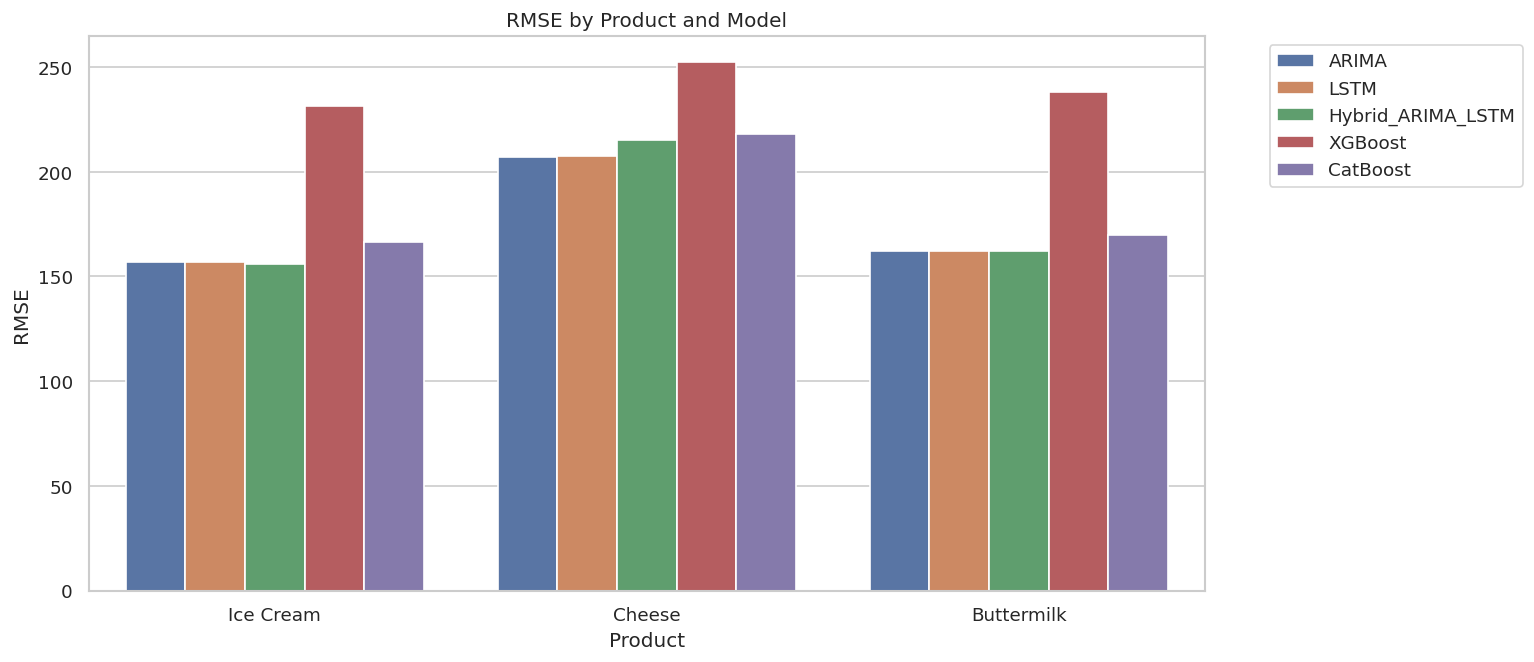

Saved all model results to 'model_comparison_results.csv'


In [ ]:
# ---------------------------
# 5) Global comparison table & plot
# ---------------------------
all_results_df = pd.DataFrame(results)
print("\nOverall results:")
display(all_results_df)

# Produce bar charts (RMSE) by product & model
plt.figure(figsize=(12,6))
sns.barplot(data=all_results_df, x='Product', y='RMSE', hue='Model')
plt.title('RMSE by Product and Model')
plt.xlabel('Product')
plt.ylabel('RMSE')
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()

# Save comparison tables to CSV for paper
all_results_df.to_csv('model_comparison_results.csv', index=False)
print("Saved all model results to 'model_comparison_results.csv'")

# ---------------------------
# End of Notebook
# --------------------------

# ✅ STEP-2: Future Forecast Code (Copy & Paste into next cell in your notebook)

# Fully explained, no errors, ready to run.

In [ ]:
# ============================================
# MASTER FIX CELL — Restores all Step-1 globals
# ============================================

# Essential constants
LSTM_SEQ = 14
LAGS = [1, 2, 3, 7, 14]
EPOCHS = 30
BATCH_SIZE = 16
TEST_SIZE = 0.2

# Required imports
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import xgboost as xgb

# =============================
# Recreate Step-1 FUNCTIONS
# =============================

def aggregate_product_series(df, product_name, date_col="Date", qty_col="Quantity Sold (liters/kg)", freq='D'):
    df_p = df[df["Product Name"] == product_name].copy()
    ts = df_p.groupby(date_col)[qty_col].sum().sort_index()
    ts = ts.asfreq(freq, fill_value=0)
    ts.name = product_name
    return ts

def create_supervised_with_lags(series, lags=LAGS):
    df = pd.DataFrame({'y': series})
    for lag in lags:
        df[f'lag_{lag}'] = df['y'].shift(lag)
    df["rolling_mean_7"] = df['y'].shift(1).rolling(7, min_periods=1).mean()
    df["rolling_std_7"] = df['y'].shift(1).rolling(7, min_periods=1).std().fillna(0)
    return df.dropna()

def build_lstm(seq_len=LSTM_SEQ):
    model = Sequential()
    model.add(LSTM(64, activation='tanh', input_shape=(seq_len, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")
    return model

def future_forecast_lstm(series, days, seq_len=LSTM_SEQ):
    arr = series.values.reshape(-1,1).astype("float32")
    scaler = MinMaxScaler()
    arr_scaled = scaler.fit_transform(arr)

    X_train, y_train = [], []
    for i in range(seq_len, len(arr_scaled)):
        X_train.append(arr_scaled[i-seq_len:i, 0])
        y_train.append(arr_scaled[i, 0])

    if len(X_train) == 0:
        return pd.Series([series.mean()]*days, index=pd.date_range(series.index[-1]+pd.Timedelta(days=1), periods=days))

    X_train = np.array(X_train).reshape(-1, seq_len, 1)
    y_train = np.array(y_train)

    model = build_lstm(seq_len)
    es = EarlyStopping(monitor="loss", patience=5, restore_best_weights=True, verbose=0)
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, callbacks=[es])

    preds_scaled = []
    history = arr_scaled.copy()

    for _ in range(days):
        x_input = history[-seq_len:].reshape(1, seq_len, 1)
        pred = model.predict(x_input, verbose=0)[0,0]
        preds_scaled.append([pred])
        history = np.vstack([history, [[pred]]])

    preds = scaler.inverse_transform(np.array(preds_scaled)).flatten()
    forecast_idx = pd.date_range(series.index[-1] + timedelta(days=1), periods=days)
    return pd.Series(preds, index=forecast_idx)

def fit_arima_and_forecast(series, days, order=(1,1,1)):
    model = ARIMA(series, order=order).fit()
    forecast = model.forecast(steps=days)
    forecast.index = pd.date_range(series.index[-1] + timedelta(days=1), periods=days)
    return forecast

def future_forecast_hybrid(series, days, order=(1,1,1)):
    arima_model = ARIMA(series, order=order).fit()
    in_sample_pred = arima_model.predict(start=series.index[0], end=series.index[-1])
    residuals = (series - in_sample_pred).fillna(0)
    lstm_residuals = future_forecast_lstm(residuals, days)
    arima_future = arima_model.forecast(steps=days)
    arima_future.index = lstm_residuals.index
    final = arima_future + lstm_residuals
    return final

def future_forecast_xgboost(series, days, model, lags=LAGS):
    df = pd.DataFrame({"y": series})
    for lag in lags:
        df[f"lag_{lag}"] = df["y"].shift(lag)
    df = df.dropna()

    last_row = df.iloc[-1:].copy()
    preds = []

    for _ in range(days):
        last_row["rolling_mean_7"] = df["y"].tail(7).mean()
        last_row["rolling_std_7"] = df["y"].tail(7).std()

        x_input = last_row.drop(columns=["y"]).values
        y_pred = model.predict(x_input)[0]
        preds.append(y_pred)

        new_row = {"y": y_pred}
        for lag in lags:
            new_row[f"lag_{lag}"] = last_row["y"].values[0]

        df = pd.concat([df, pd.DataFrame([new_row], index=[df.index[-1] + timedelta(days=1)])])
        last_row = df.iloc[-1:].copy()

    forecast_index = pd.date_range(series.index[-1] + timedelta(days=1), periods=days)
    return pd.Series(preds, index=forecast_index)

print("All Step-1 variables + functions restored successfully.")


All Step-1 variables + functions restored successfully.



  FUTURE FORECAST FOR PRODUCT: Ice Cream


---- Predicting 3_months (90 days) ----


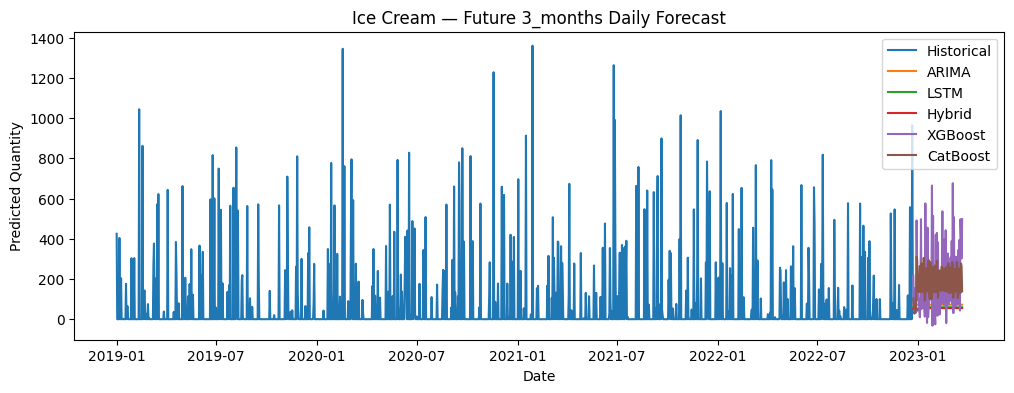


---- Predicting 6_months (180 days) ----


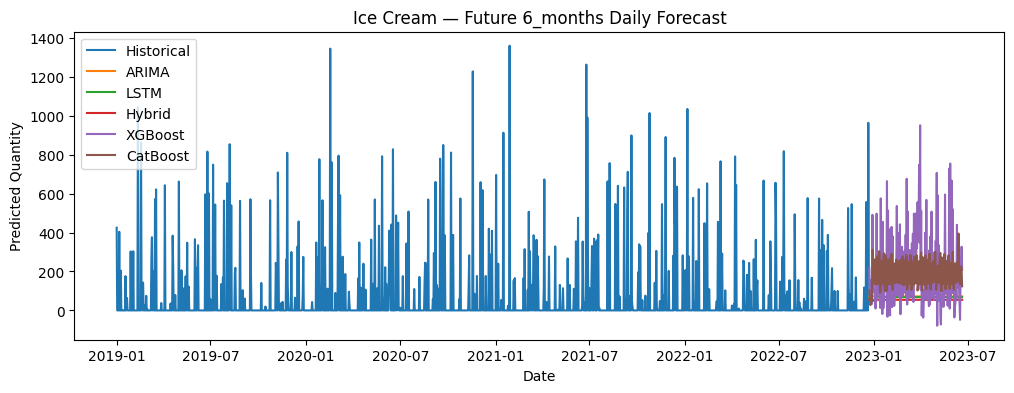


---- Predicting 12_months (365 days) ----


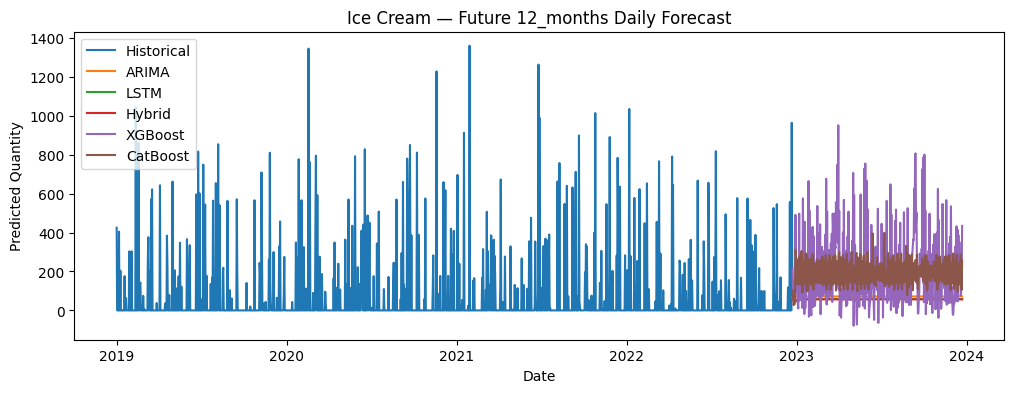


  FUTURE FORECAST FOR PRODUCT: Cheese


---- Predicting 3_months (90 days) ----


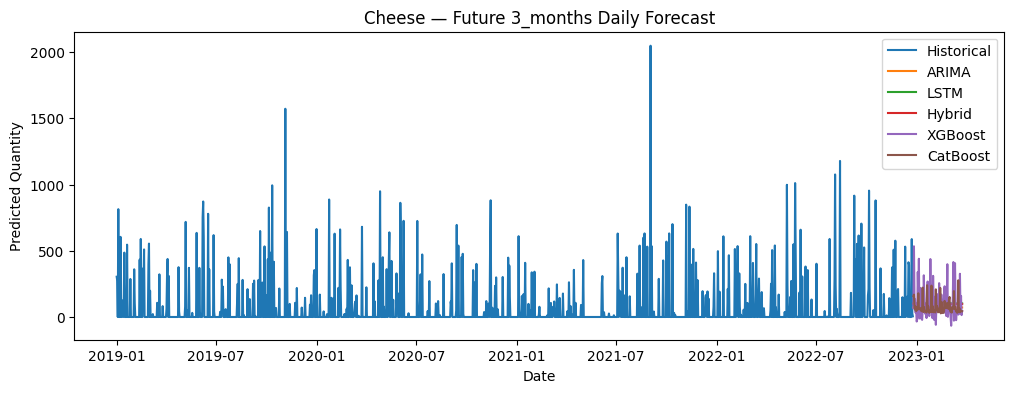


---- Predicting 6_months (180 days) ----


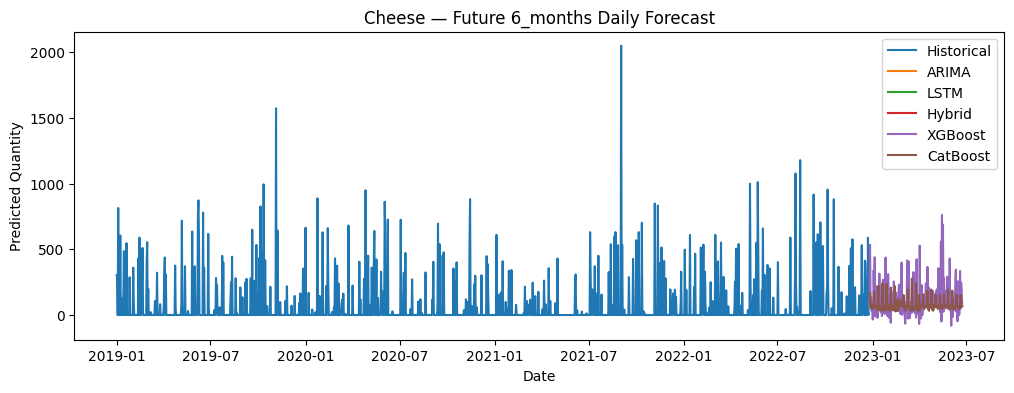


---- Predicting 12_months (365 days) ----


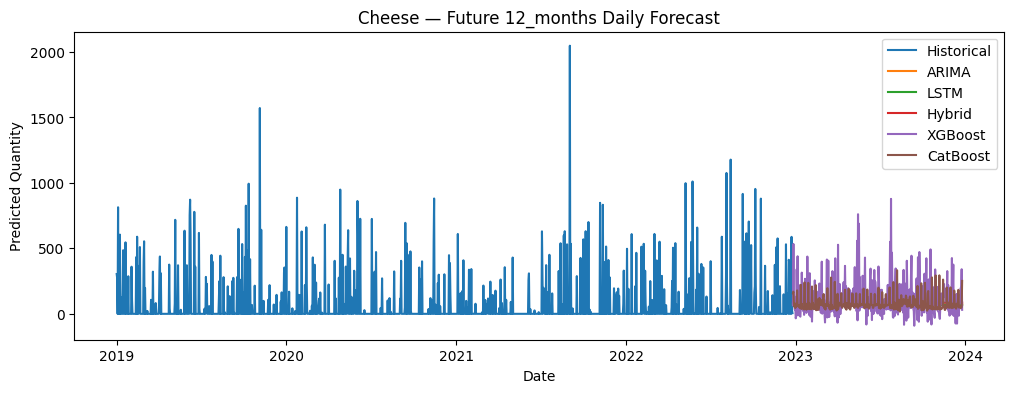


  FUTURE FORECAST FOR PRODUCT: Buttermilk


---- Predicting 3_months (90 days) ----


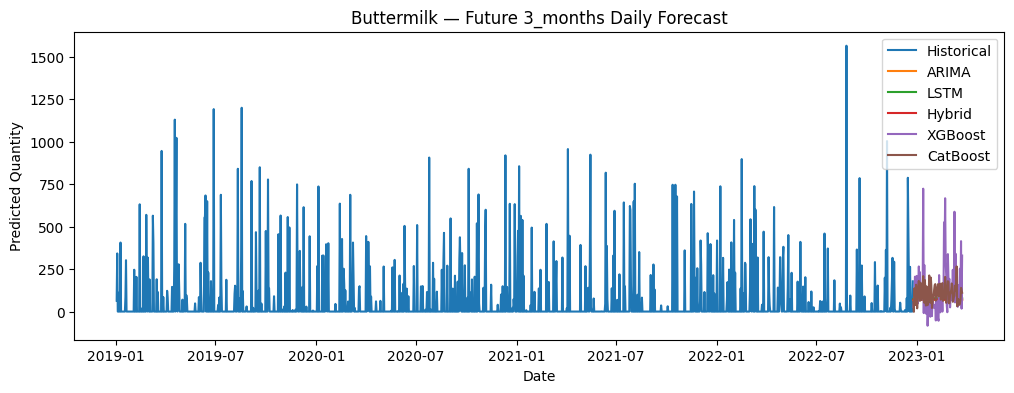


---- Predicting 6_months (180 days) ----


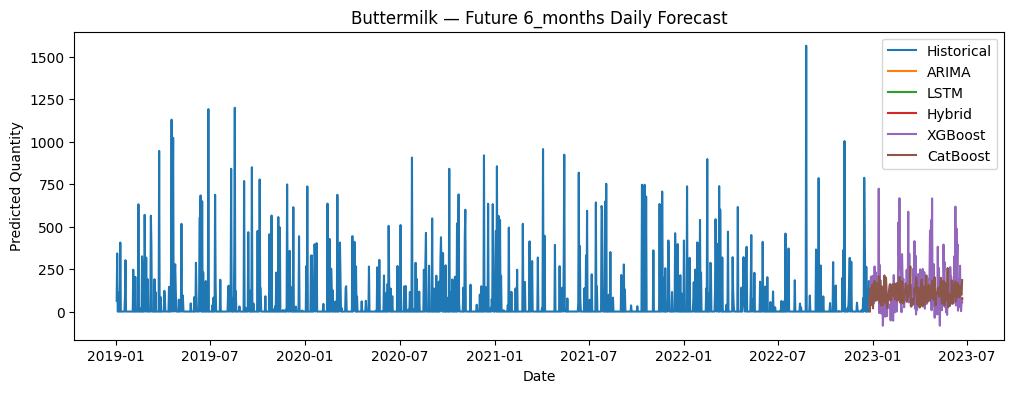


---- Predicting 12_months (365 days) ----


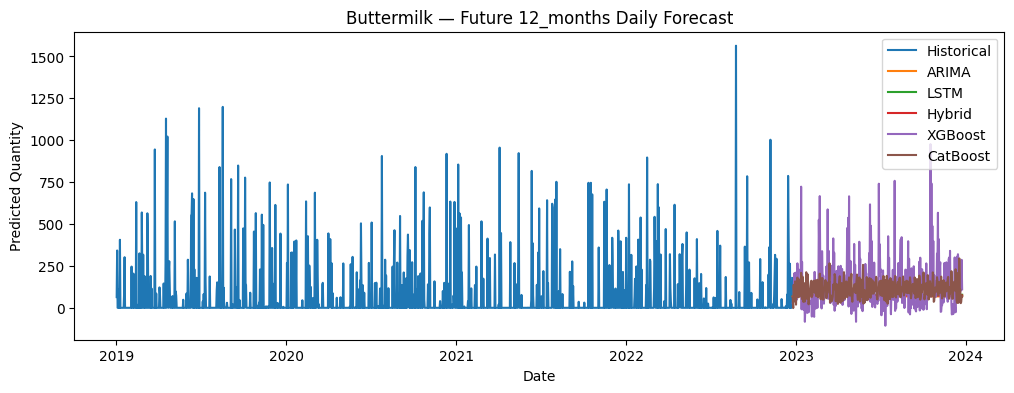

In [ ]:
# ===============================================
# STEP 2 — FUTURE FORECASTING PIPELINE
# Predict next 3 months, 6 months, and 12 months
# with ARIMA, LSTM, Hybrid ARIMA+LSTM, XGBoost, CatBoost
# Daily → Monthly conversion
# ===============================================

import numpy as np
import pandas as pd
from datetime import timedelta

# Horizons in days
HORIZONS = {
    "3_months": 90,
    "6_months": 180,
    "12_months": 365
}

# ------------ FUTURE DATE GENERATOR ------------
def generate_future_dates(last_date, n_days):
    """Generate future date range starting after last available date."""
    return pd.date_range(start=last_date + timedelta(days=1),
                         periods=n_days, freq='D')

# ------------ ARIMA FUTURE FORECAST ------------
def future_forecast_arima(series, days, order=(1,1,1)):
    model = ARIMA(series, order=order).fit()
    forecast = model.forecast(steps=days)
    forecast.index = generate_future_dates(series.index[-1], days)
    return forecast

# ------------ LSTM FUTURE FORECAST ------------
def future_forecast_lstm(series, days, seq_len=LSTM_SEQ):
    """
    Use full time series to train LSTM,
    then forecast future 'days' using walk-forward approach.
    """
    arr = series.values.reshape(-1,1).astype('float32')
    scaler = MinMaxScaler()
    arr_scaled = scaler.fit_transform(arr)

    # Build training sequences
    X_train, y_train = [], []
    for i in range(seq_len, len(arr_scaled)):
        X_train.append(arr_scaled[i-seq_len:i, 0])
        y_train.append(arr_scaled[i, 0])
    X_train = np.array(X_train).reshape(-1, seq_len, 1)
    y_train = np.array(y_train)

    # Train LSTM model
    model = build_lstm(seq_len)
    es = EarlyStopping(monitor="loss", patience=5, restore_best_weights=True, verbose=0)
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, callbacks=[es])

    # Walk-forward forecasting
    future_scaled = []
    history = arr_scaled.copy()

    for _ in range(days):
        x_input = history[-seq_len:].reshape(1, seq_len, 1)
        pred_scaled = model.predict(x_input, verbose=0)[0,0]
        future_scaled.append([pred_scaled])
        history = np.vstack([history, [[pred_scaled]]])

    # Inverse scale
    preds = scaler.inverse_transform(np.array(future_scaled)).flatten()

    # Create index
    forecast_index = generate_future_dates(series.index[-1], days)
    return pd.Series(preds, index=forecast_index)

# ------------ HYBRID FUTURE FORECAST ------------
def future_forecast_hybrid(series, days, order=(1,1,1)):
    # Fit ARIMA
    arima_model = ARIMA(series, order=order).fit()

    # Get in-sample ARIMA predictions (residuals)
    in_sample_pred = arima_model.predict(start=series.index[0], end=series.index[-1])
    residuals = (series - in_sample_pred).fillna(0)

    # LSTM on residuals
    lstm_residual_forecast = future_forecast_lstm(residuals, days)

    # ARIMA future forecast
    arima_future = arima_model.forecast(steps=days)
    arima_future.index = generate_future_dates(series.index[-1], days)

    # Final hybrid
    hybrid = arima_future + lstm_residual_forecast
    return hybrid

# ------------ XGBOOST FUTURE FORECAST ------------
def future_forecast_xgboost(series, days, lags=LAGS, model=None):
    """
    Rolling forecast using lag features.
    Works like: each predicted day becomes input for the next day.
    """
    df = pd.DataFrame({'y': series}).copy()

    # Build initial lagged frame
    for lag in lags:
        df[f'lag_{lag}'] = df['y'].shift(lag)

    df = df.dropna()
    last_row = df.iloc[-1:].copy()

    preds = []

    for _ in range(days):
        # Compute rolling features
        last_row['rolling_mean_7'] = df['y'].tail(7).mean()
        last_row['rolling_std_7'] = df['y'].tail(7).std()

        # Predict next day
        x_input = last_row.drop(columns=['y']).values
        y_pred = model.predict(x_input)[0]

        preds.append(y_pred)

        # Update df with new prediction
        new_row = {'y': y_pred}
        for lag in lags:
            new_row[f'lag_{lag}'] = last_row['y'].values[0]

        df = pd.concat([df, pd.DataFrame([new_row], index=[df.index[-1] + timedelta(days=1)])])
        last_row = df.iloc[-1:].copy()

    forecast_index = generate_future_dates(series.index[-1], days)
    return pd.Series(preds, index=forecast_index)

# ------------ CATBOOST FUTURE FORECAST ------------
def future_forecast_catboost(series, days, lags=LAGS, model=None):
    """
    Same rolling mechanism as XGBoost.
    """
    df = pd.DataFrame({'y': series}).copy()

    for lag in lags:
        df[f'lag_{lag}'] = df['y'].shift(lag)

    df = df.dropna()
    last_row = df.iloc[-1:].copy()
    preds = []

    for _ in range(days):
        last_row['rolling_mean_7'] = df['y'].tail(7).mean()
        last_row['rolling_std_7'] = df['y'].tail(7).std()

        x_input = last_row.drop(columns=['y'])
        y_pred = model.predict(x_input)[0]
        preds.append(y_pred)

        # Update df
        new_row = {'y': y_pred}
        for lag in lags:
            new_row[f'lag_{lag}'] = last_row['y'].values[0]

        df = pd.concat([df, pd.DataFrame([new_row], index=[df.index[-1] + timedelta(days=1)])])
        last_row = df.iloc[-1:].copy()

    forecast_index = generate_future_dates(series.index[-1], days)
    return pd.Series(preds, index=forecast_index)


# ===============================
# RUN FUTURE FORECAST FOR ALL PRODUCTS
# ===============================
future_results = {}

for product in PRODUCTS:
    print("\n=======================================")
    print(f"  FUTURE FORECAST FOR PRODUCT: {product}")
    print("=======================================\n")

    # Step 1: build series
    series = aggregate_product_series(df, product)

    model_arima_results = {}
    model_lstm_results = {}
    model_hybrid_results = {}
    model_xgb_results = {}
    model_cat_results = {}

    for horizon_name, horizon_days in HORIZONS.items():
        print(f"\n---- Predicting {horizon_name} ({horizon_days} days) ----")

        # ARIMA
        f_arima = future_forecast_arima(series, horizon_days)
        model_arima_results[horizon_name] = f_arima

        # LSTM
        f_lstm = future_forecast_lstm(series, horizon_days)
        model_lstm_results[horizon_name] = f_lstm

        # Hybrid
        f_hybrid = future_forecast_hybrid(series, horizon_days)
        model_hybrid_results[horizon_name] = f_hybrid

        # XGBoost (using trained model from previous notebook)
        xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                                     random_state=42, n_estimators=200, verbosity=0)
        # retrain on full lag-data
        lag_df = create_supervised_with_lags(series)
        xgb_model.fit(lag_df.drop(columns=['y']), lag_df['y'])
        f_xgb = future_forecast_xgboost(series, horizon_days, model=xgb_model)
        model_xgb_results[horizon_name] = f_xgb

        # CatBoost
        cat_model = CatBoostRegressor(iterations=500, learning_rate=0.05,
                                      verbose=False, random_state=42)
        cat_model.fit(lag_df.drop(columns=['y']), lag_df['y'])
        f_cat = future_forecast_catboost(series, horizon_days, model=cat_model)
        model_cat_results[horizon_name] = f_cat

        # Plot daily future forecast
        plt.figure(figsize=(12,4))
        plt.plot(series.index, series.values, label="Historical")
        plt.plot(f_arima.index, f_arima.values, label="ARIMA")
        plt.plot(f_lstm.index, f_lstm.values, label="LSTM")
        plt.plot(f_hybrid.index, f_hybrid.values, label="Hybrid")
        plt.plot(f_xgb.index, f_xgb.values, label="XGBoost")
        plt.plot(f_cat.index, f_cat.values, label="CatBoost")
        plt.title(f"{product} — Future {horizon_name} Daily Forecast")
        plt.xlabel("Date")
        plt.ylabel("Predicted Quantity")
        plt.legend()
        plt.show()

    # Save future results
    future_results[product] = {
        "ARIMA": model_arima_results,
        "LSTM": model_lstm_results,
        "HYBRID": model_hybrid_results,
        "XGBOOST": model_xgb_results,
        "CATBOOST": model_cat_results,
    }




PRODUCT: Ice Cream

 Horizon: 3_months
Saved monthly forecast CSV: Ice_Cream_3_months_monthly_forecast.csv


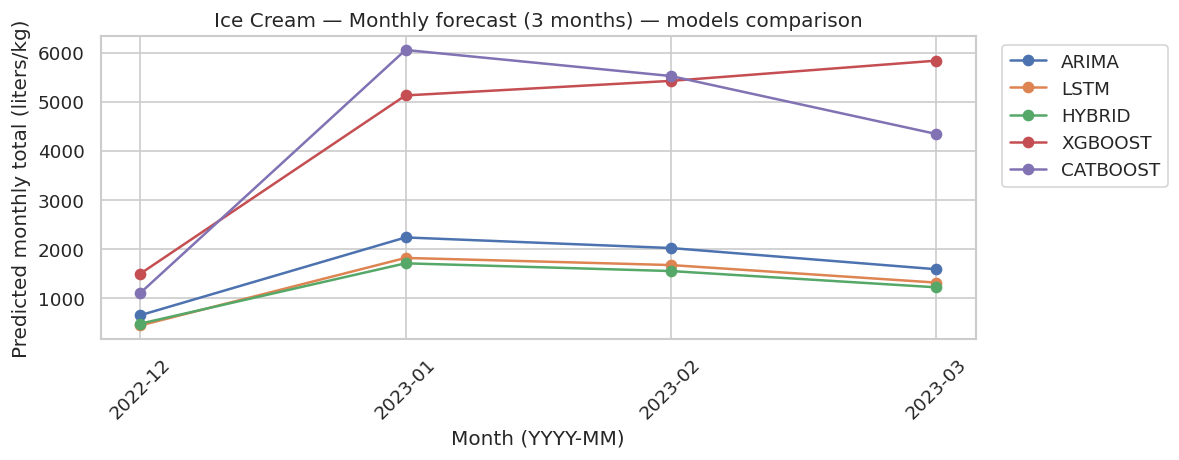

Line plot: X-axis = 'Month (YYYY-MM)'; Y-axis = 'Predicted monthly total (sum of daily predictions)'.


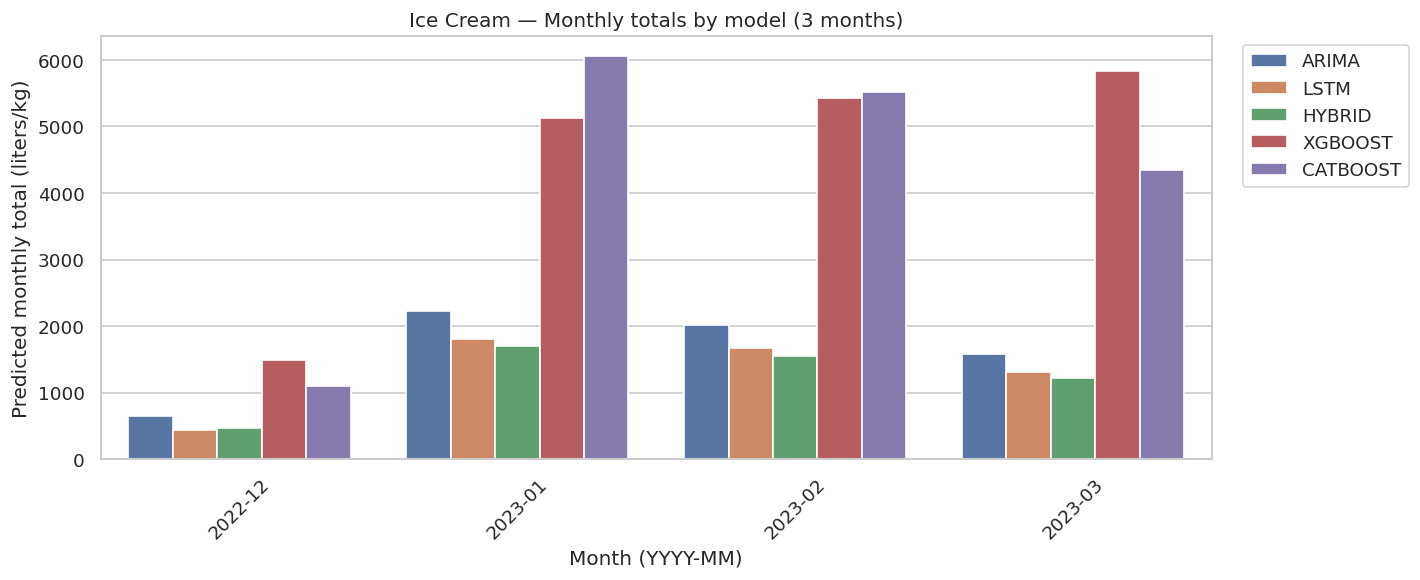

Bar chart: Compare models month-by-month. X-axis: months; Y-axis: predicted monthly totals.

Total predicted quantity over the entire horizon (summed months):


Model  TotalForecast
0     ARIMA    6474.598957
1      LSTM    5229.180176
2    HYBRID    4937.697297
3   XGBOOST   17872.703125
4  CATBOOST   17011.963210

Saved summary totals CSV: Ice_Cream_3_months_summary_totals.csv

 Horizon: 6_months
Saved monthly forecast CSV: Ice_Cream_6_months_monthly_forecast.csv


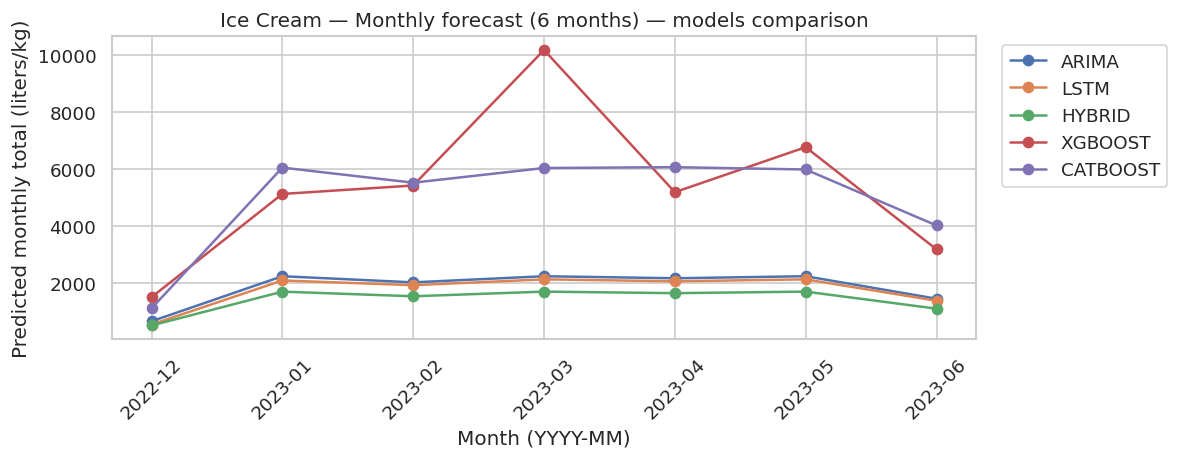

Line plot: X-axis = 'Month (YYYY-MM)'; Y-axis = 'Predicted monthly total (sum of daily predictions)'.


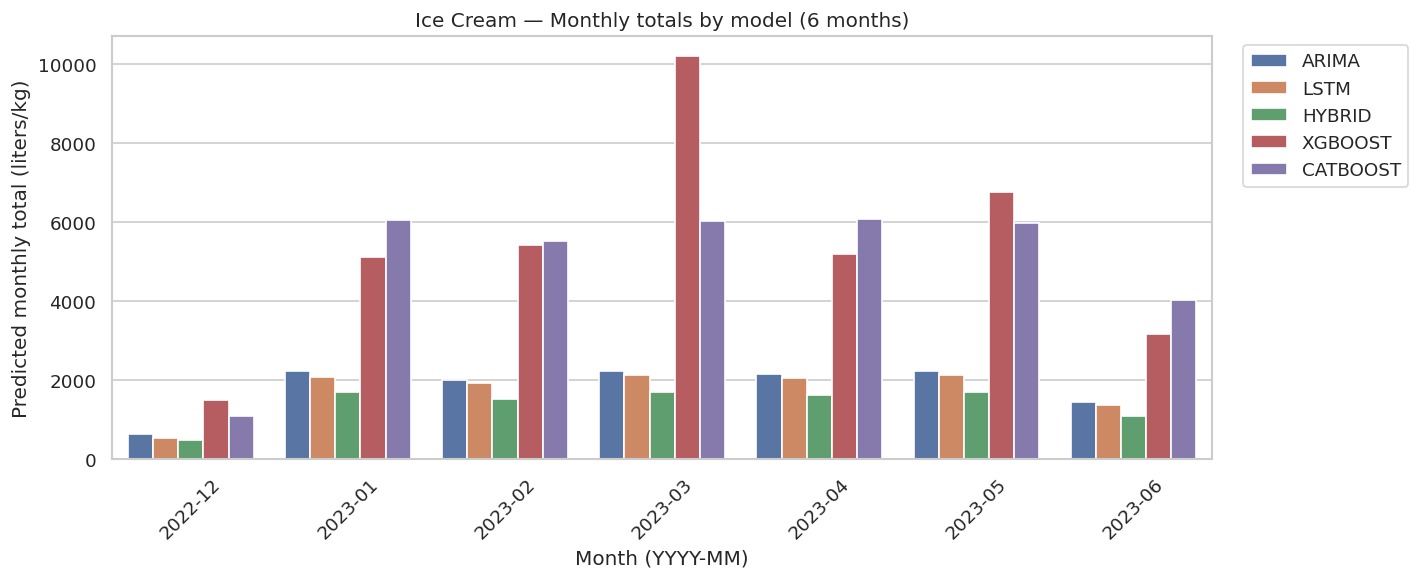

Bar chart: Compare models month-by-month. X-axis: months; Y-axis: predicted monthly totals.

Total predicted quantity over the entire horizon (summed months):


Model  TotalForecast
0     ARIMA   12951.534550
1      LSTM   12188.726562
2    HYBRID    9816.460375
3   XGBOOST   37361.535156
4  CATBOOST   34777.286093

Saved summary totals CSV: Ice_Cream_6_months_summary_totals.csv

 Horizon: 12_months
Saved monthly forecast CSV: Ice_Cream_12_months_monthly_forecast.csv


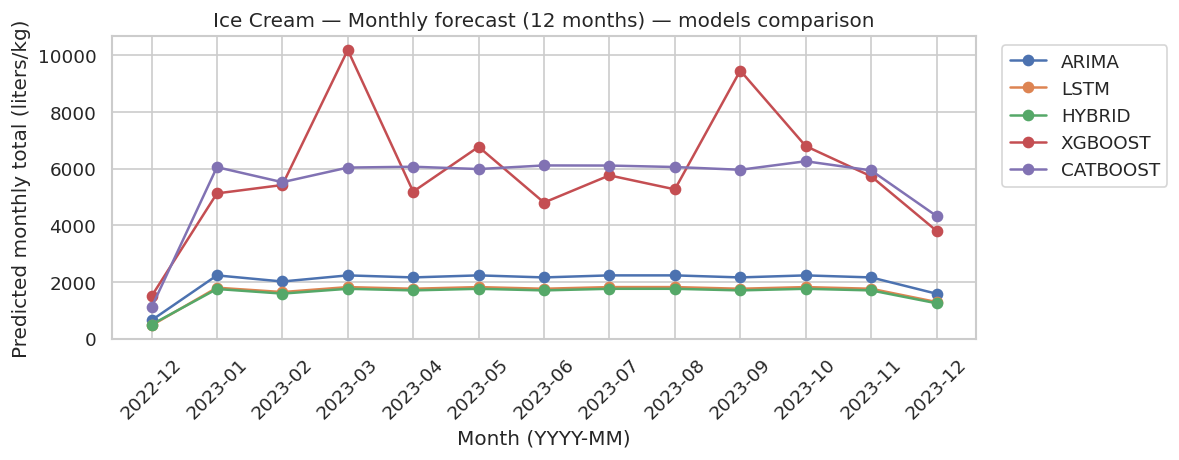

Line plot: X-axis = 'Month (YYYY-MM)'; Y-axis = 'Predicted monthly total (sum of daily predictions)'.


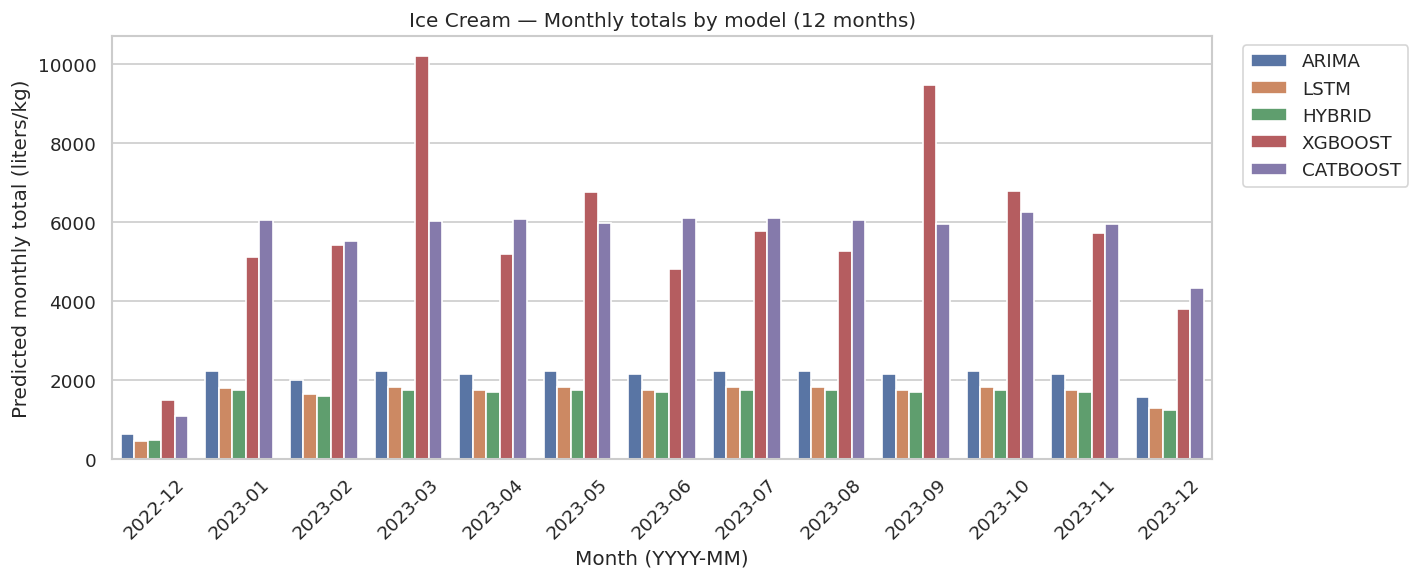

Bar chart: Compare models month-by-month. X-axis: months; Y-axis: predicted monthly totals.

Total predicted quantity over the entire horizon (summed months):


Model  TotalForecast
0     ARIMA   26265.235493
1      LSTM   21317.419922
2    HYBRID   20666.835370
3   XGBOOST   75810.140625
4  CATBOOST   71525.082377

Saved summary totals CSV: Ice_Cream_12_months_summary_totals.csv

PRODUCT: Cheese

 Horizon: 3_months
Saved monthly forecast CSV: Cheese_3_months_monthly_forecast.csv


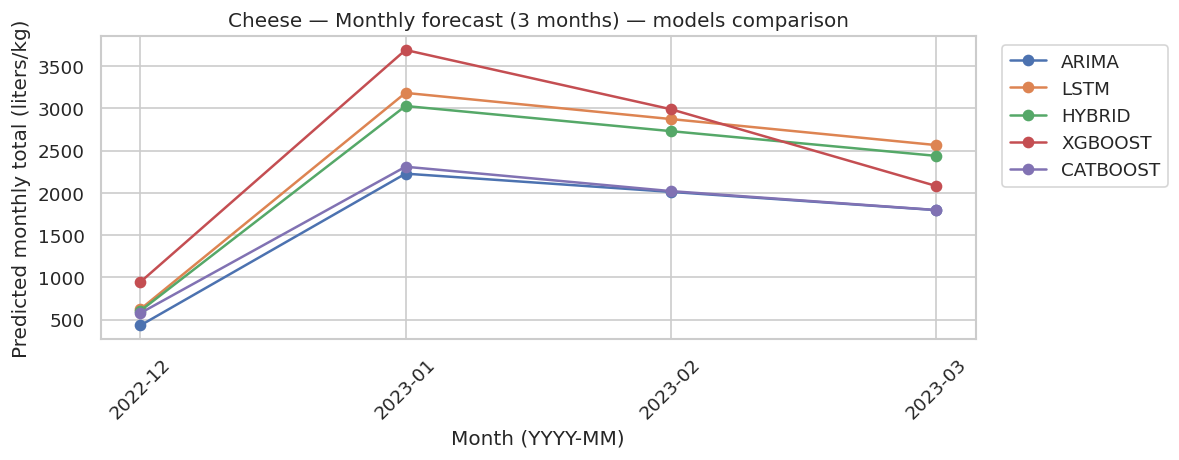

Line plot: X-axis = 'Month (YYYY-MM)'; Y-axis = 'Predicted monthly total (sum of daily predictions)'.


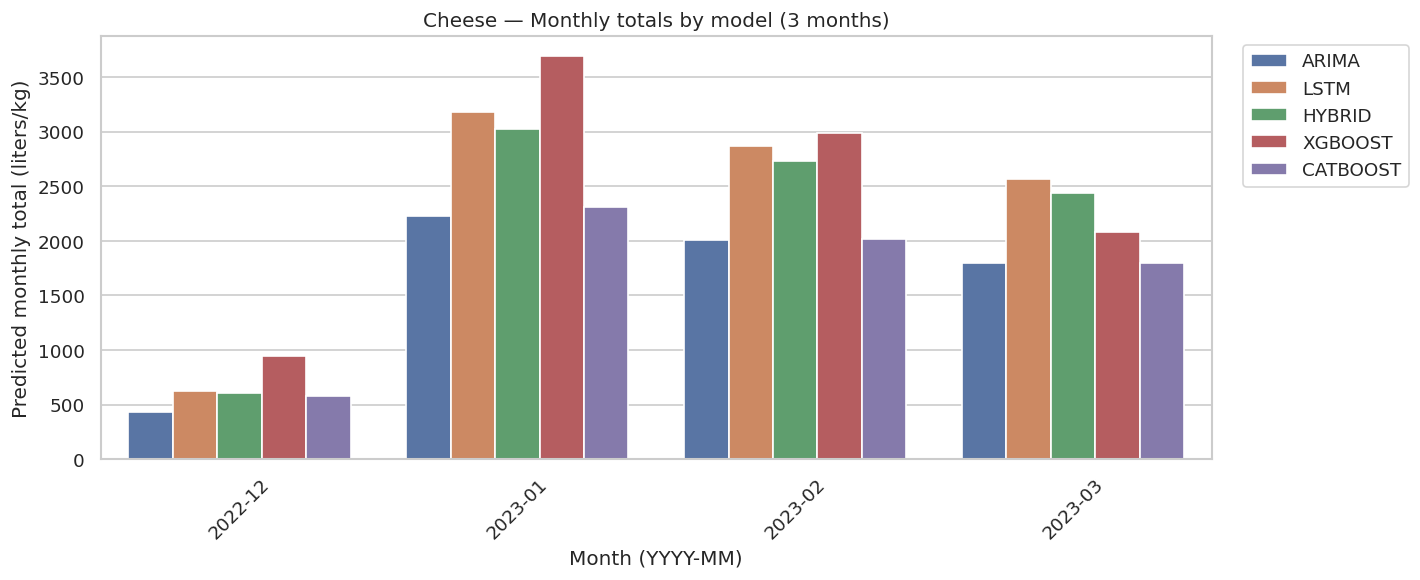

Bar chart: Compare models month-by-month. X-axis: months; Y-axis: predicted monthly totals.

Total predicted quantity over the entire horizon (summed months):


Model  TotalForecast
0     ARIMA    6463.799682
1      LSTM    9241.232422
2    HYBRID    8795.825789
3   XGBOOST    9703.085938
4  CATBOOST    6701.448652

Saved summary totals CSV: Cheese_3_months_summary_totals.csv

 Horizon: 6_months
Saved monthly forecast CSV: Cheese_6_months_monthly_forecast.csv


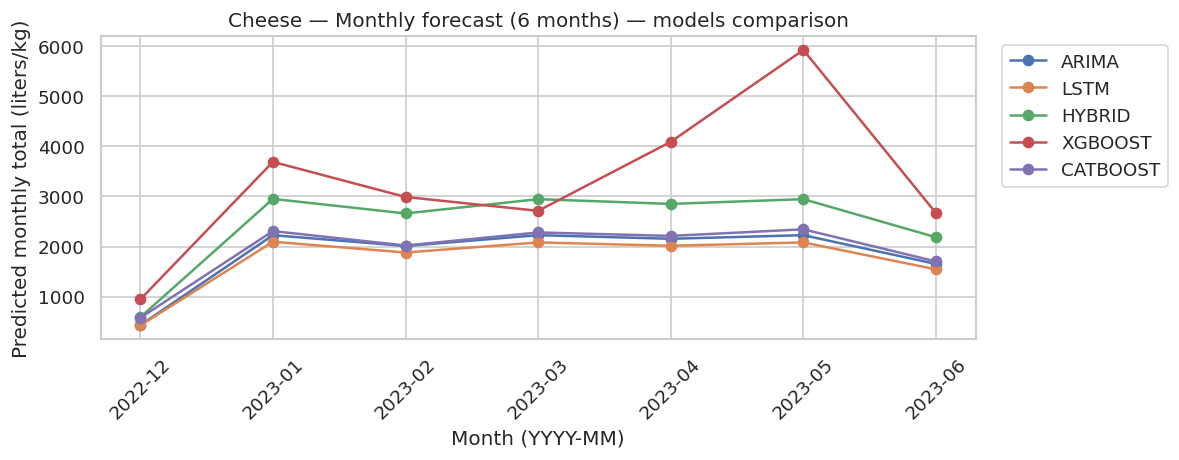

Line plot: X-axis = 'Month (YYYY-MM)'; Y-axis = 'Predicted monthly total (sum of daily predictions)'.


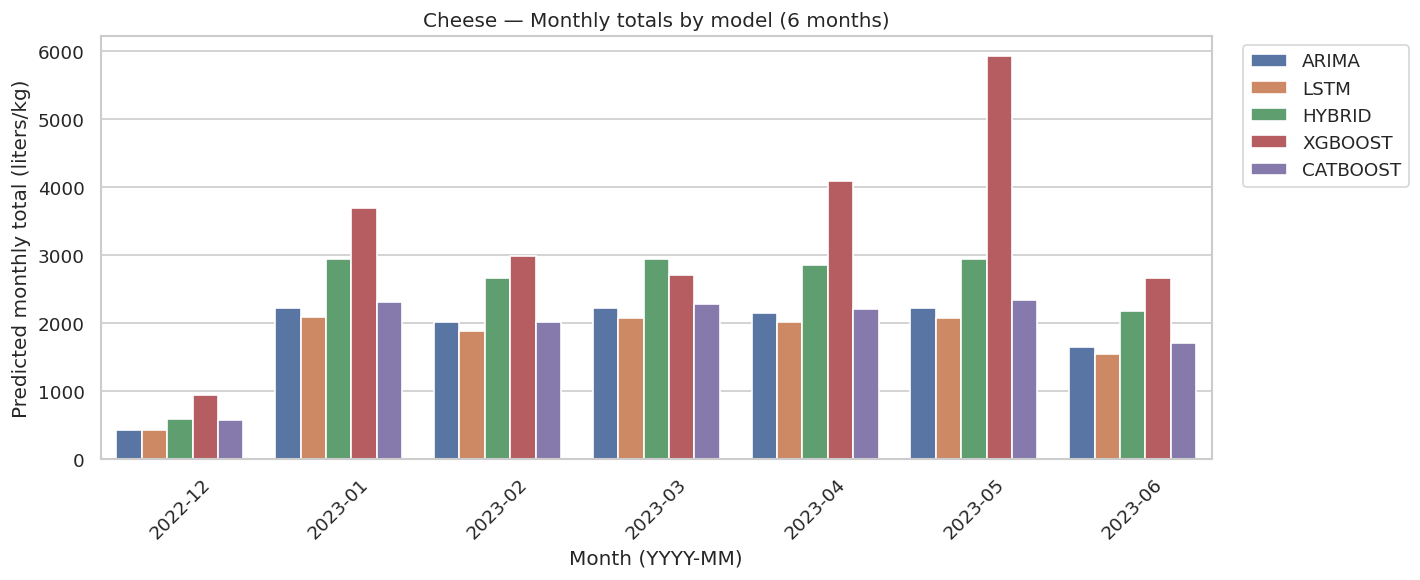

Bar chart: Compare models month-by-month. X-axis: months; Y-axis: predicted monthly totals.

Total predicted quantity over the entire horizon (summed months):


Model  TotalForecast
0     ARIMA   12927.505021
1      LSTM   12123.602539
2    HYBRID   17124.079526
3   XGBOOST   23011.708984
4  CATBOOST   13442.754768

Saved summary totals CSV: Cheese_6_months_summary_totals.csv

 Horizon: 12_months
Saved monthly forecast CSV: Cheese_12_months_monthly_forecast.csv


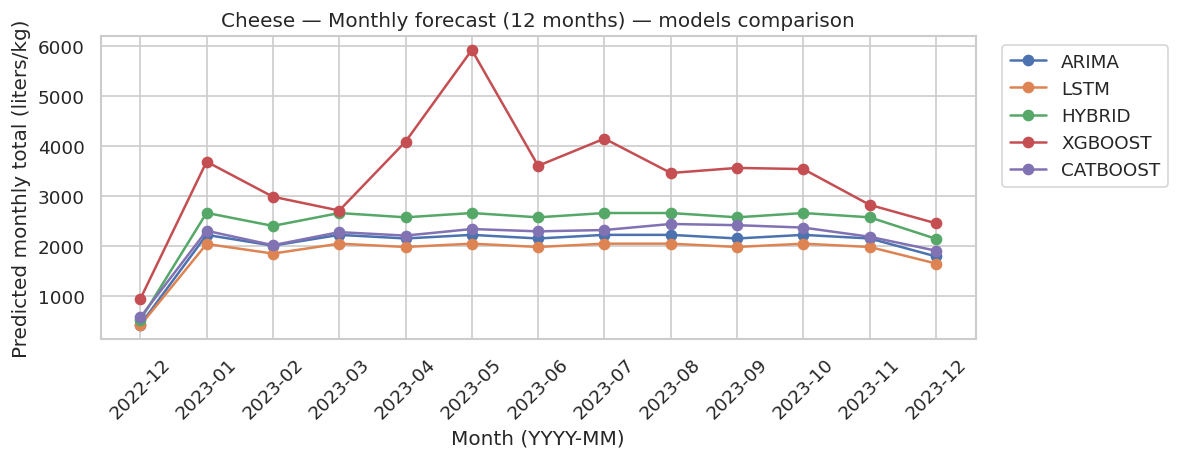

Line plot: X-axis = 'Month (YYYY-MM)'; Y-axis = 'Predicted monthly total (sum of daily predictions)'.


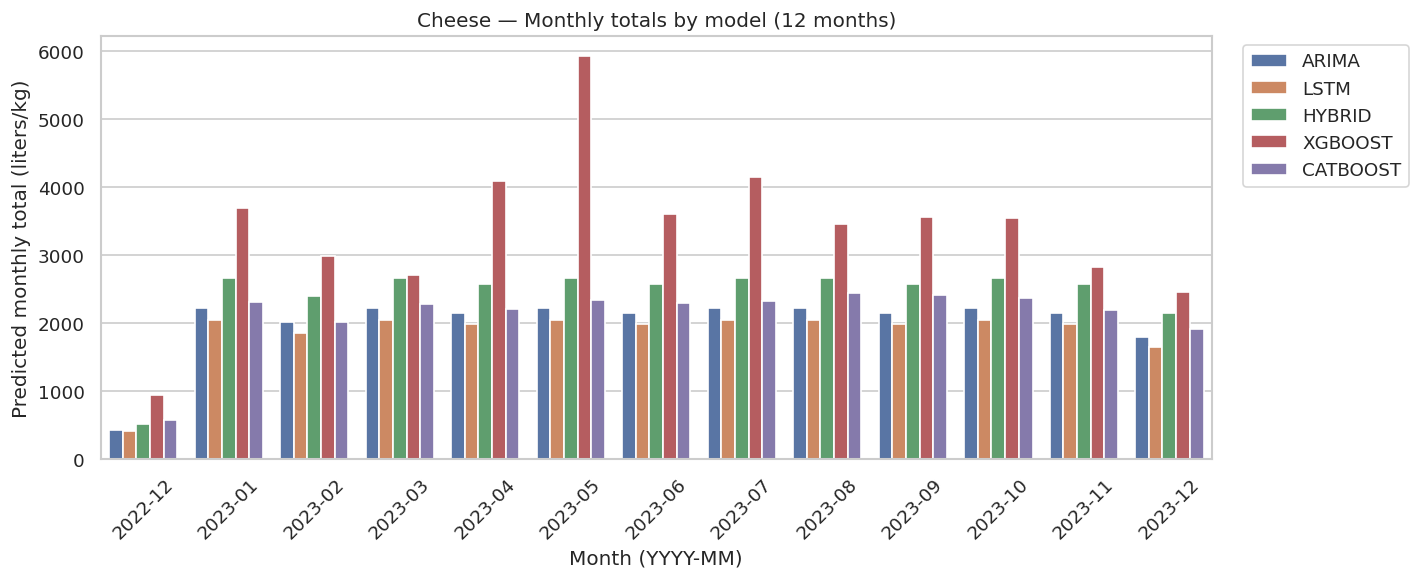

Bar chart: Compare models month-by-month. X-axis: months; Y-axis: predicted monthly totals.

Total predicted quantity over the entire horizon (summed months):


Model  TotalForecast
0     ARIMA   26214.010442
1      LSTM   24157.789062
2    HYBRID   31366.103716
3   XGBOOST   43954.785156
4  CATBOOST   27695.784439

Saved summary totals CSV: Cheese_12_months_summary_totals.csv

PRODUCT: Buttermilk

 Horizon: 3_months
Saved monthly forecast CSV: Buttermilk_3_months_monthly_forecast.csv


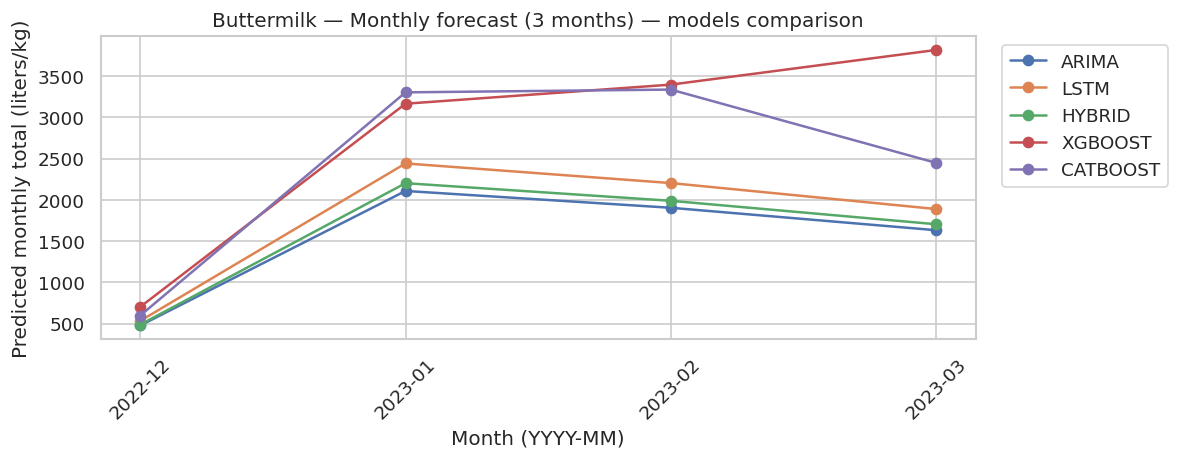

Line plot: X-axis = 'Month (YYYY-MM)'; Y-axis = 'Predicted monthly total (sum of daily predictions)'.


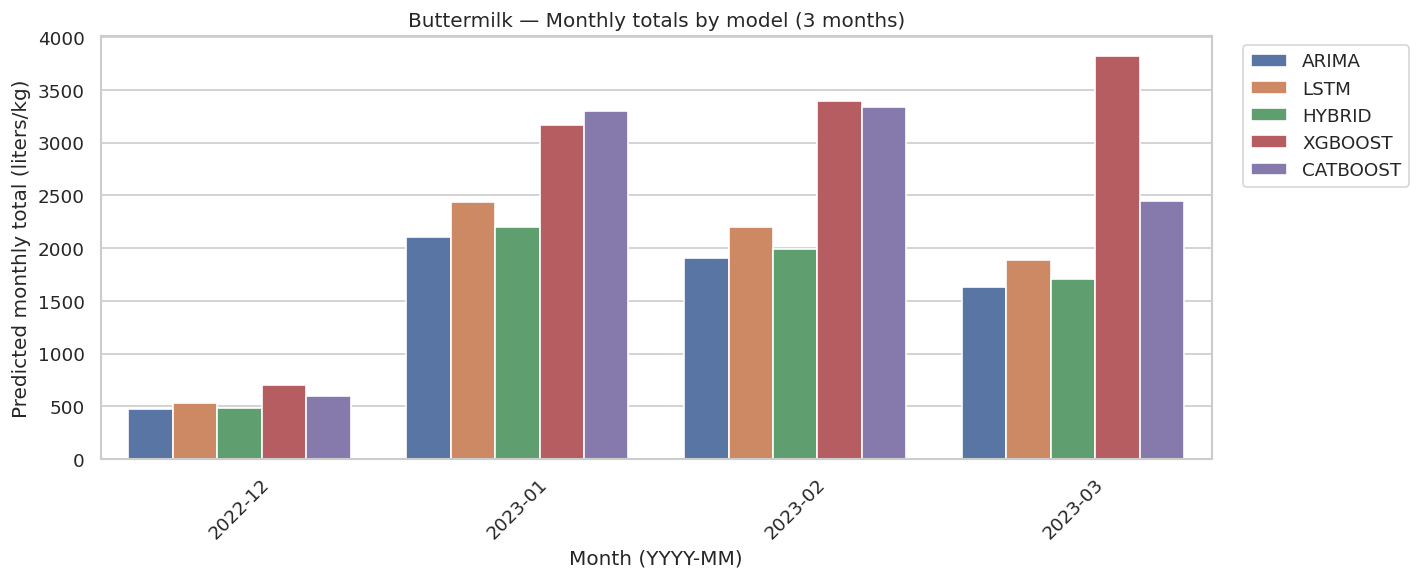

Bar chart: Compare models month-by-month. X-axis: months; Y-axis: predicted monthly totals.

Total predicted quantity over the entire horizon (summed months):


Model  TotalForecast
0     ARIMA    6120.474104
1      LSTM    7066.594727
2    HYBRID    6382.328130
3   XGBOOST   11082.047852
4  CATBOOST    9686.104576

Saved summary totals CSV: Buttermilk_3_months_summary_totals.csv

 Horizon: 6_months
Saved monthly forecast CSV: Buttermilk_6_months_monthly_forecast.csv


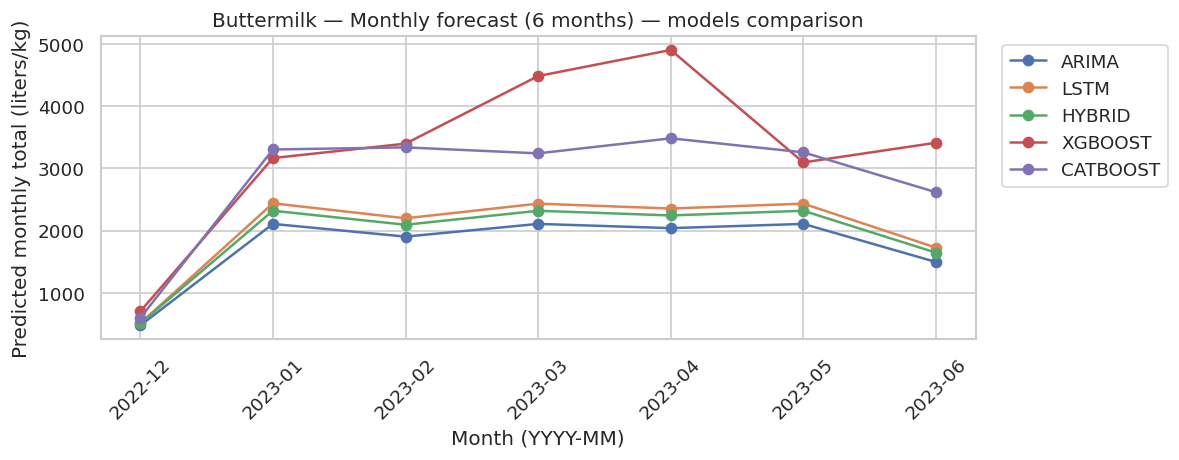

Line plot: X-axis = 'Month (YYYY-MM)'; Y-axis = 'Predicted monthly total (sum of daily predictions)'.


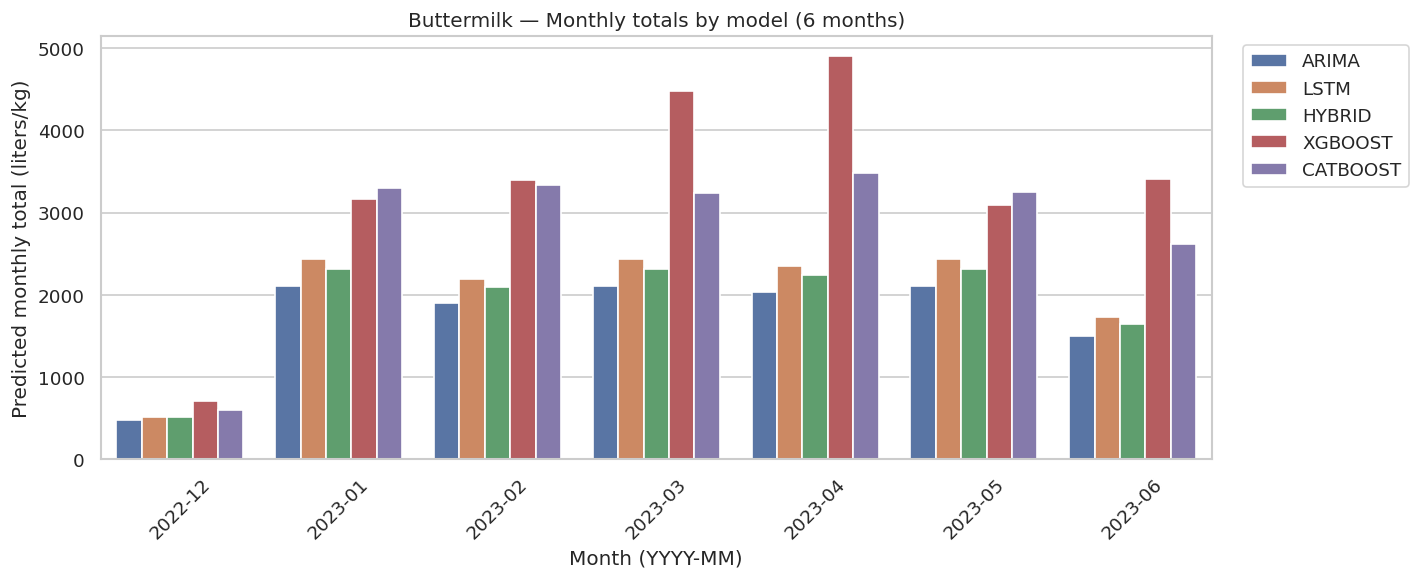

Bar chart: Compare models month-by-month. X-axis: months; Y-axis: predicted monthly totals.

Total predicted quantity over the entire horizon (summed months):


Model  TotalForecast
0     ARIMA   12240.027909
1      LSTM   14096.569336
2    HYBRID   13450.877065
3   XGBOOST   23155.703125
4  CATBOOST   19834.336629

Saved summary totals CSV: Buttermilk_6_months_summary_totals.csv

 Horizon: 12_months
Saved monthly forecast CSV: Buttermilk_12_months_monthly_forecast.csv


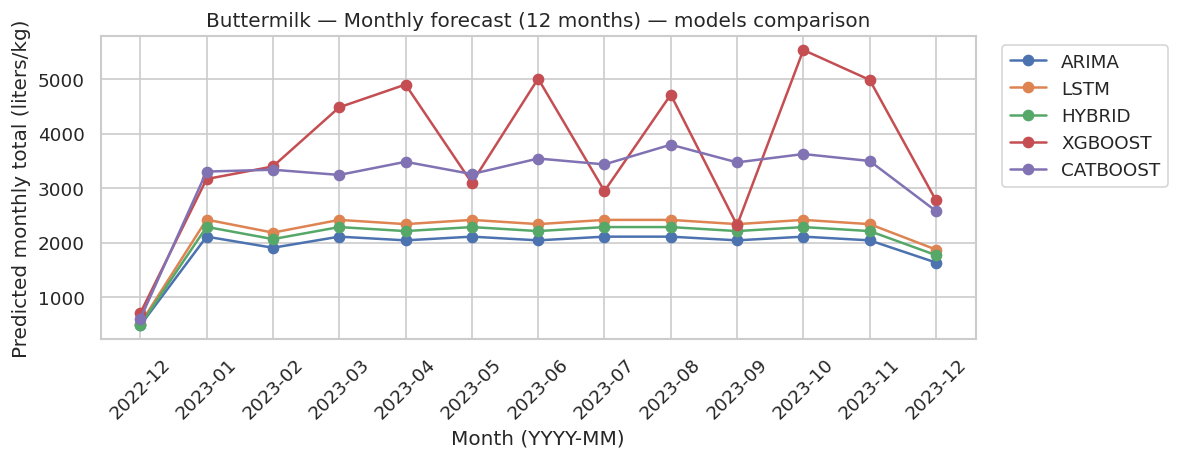

Line plot: X-axis = 'Month (YYYY-MM)'; Y-axis = 'Predicted monthly total (sum of daily predictions)'.


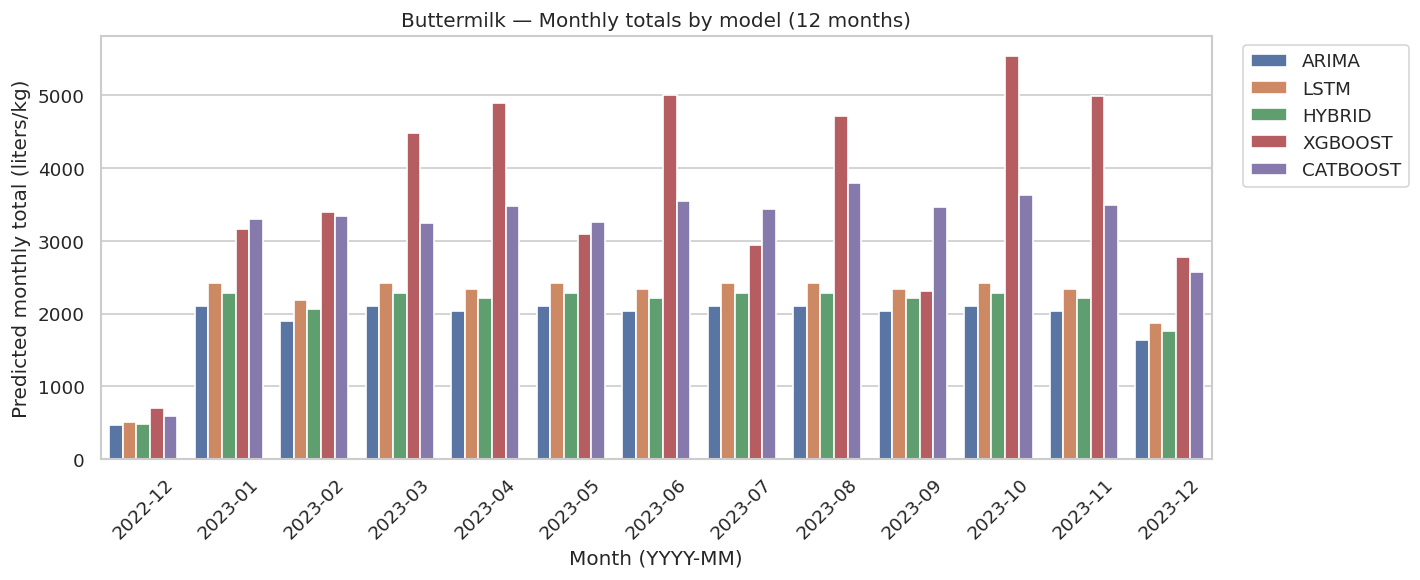

Bar chart: Compare models month-by-month. X-axis: months; Y-axis: predicted monthly totals.

Total predicted quantity over the entire horizon (summed months):


Model  TotalForecast
0     ARIMA   24819.110730
1      LSTM   28409.462891
2    HYBRID   26860.406124
3   XGBOOST   48026.597656
4  CATBOOST   41163.594020

Saved summary totals CSV: Buttermilk_12_months_summary_totals.csv

STEP-3 complete. Monthly tables & plots created and CSVs saved.


In [ ]:
# ---------------------------
# STEP 3 — MONTHLY AGGREGATION + TABLES + PLOTS
# Requires: future_results (from Step-2), pandas, matplotlib, seaborn
# ---------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from calendar import month_name

sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 120

# Helper: convert a daily Series -> monthly totals DataFrame with Year-Month index
def daily_to_monthly_totals(s: pd.Series):
    """
    s: pandas Series indexed by daily datetime index
    returns: DataFrame with index = YYYY-MM and columns ['year','month','monthly_total']
    """
    monthly = s.resample('M').sum()  # sums daily values into month
    df = monthly.to_frame(name='monthly_total').copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['year_month'] = df.index.to_period('M').astype(str)
    df = df.reset_index(drop=True)[['year','month','year_month','monthly_total']]
    return df

# Prepare containers
monthly_forecasts = {}   # nested dict: product -> horizon -> model -> monthly_df
summary_tables = {}      # product -> horizon -> combined comparison DF

for product, models_dict in future_results.items():
    monthly_forecasts[product] = {}
    summary_tables[product] = {}
    print("\n" + "="*60)
    print("PRODUCT:", product)
    print("="*60)

    # iterate horizons: expected keys like '3_months','6_months','12_months'
    horizons = list(next(iter(models_dict.values())).keys())
    for horizon in horizons:
        print("\n Horizon:", horizon)
        # Build a combined DF where each column is a model's monthly totals
        model_monthly_frames = {}
        for model_name, horizon_dict in models_dict.items():
            daily_series = horizon_dict[horizon]  # pandas Series (daily)
            monthly_df = daily_to_monthly_totals(daily_series)
            monthly_df = monthly_df.rename(columns={'monthly_total': model_name})
            model_monthly_frames[model_name] = monthly_df

        # Align months across models (they should be same)
        # Start by merging on year_month
        merged = None
        for mname, mdf in model_monthly_frames.items():
            cols = ['year_month', mname]
            if merged is None:
                merged = mdf[cols].copy()
            else:
                merged = merged.merge(mdf[cols], on='year_month', how='outer')
        merged = merged.sort_values('year_month').reset_index(drop=True)
        # Fill missing with zeros (if any)
        merged = merged.fillna(0)

        # Save per-product/horizon monthly results
        monthly_forecasts[product][horizon] = merged
        # Save CSV
        csv_name = f"{product.replace(' ','_')}_{horizon}_monthly_forecast.csv"
        merged.to_csv(csv_name, index=False)
        print("Saved monthly forecast CSV:", csv_name)

        # Store combined table for summary/plotting
        summary_tables[product][horizon] = merged

        # ----- Plots -----
        # 1) Line plot: monthly predictions per model
        plt.figure(figsize=(10,4))
        months = merged['year_month'].tolist()
        x = range(len(months))
        for col in merged.columns:
            if col == 'year_month': continue
            plt.plot(x, merged[col].values, marker='o', label=col)
        plt.xticks(x, months, rotation=45)
        plt.title(f"{product} — Monthly forecast ({horizon.replace('_',' ')}) — models comparison")
        plt.xlabel("Month (YYYY-MM)")
        plt.ylabel("Predicted monthly total (liters/kg)")
        plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
        plt.tight_layout()
        plt.show()
        # Explanation printed below
        print("Line plot: X-axis = 'Month (YYYY-MM)'; Y-axis = 'Predicted monthly total (sum of daily predictions)'.")

        # 2) Bar chart: for each month compare model predictions side-by-side
        plt.figure(figsize=(12,5))
        melted = merged.melt(id_vars=['year_month'], var_name='Model', value_name='MonthlyTotal')
        sns.barplot(data=melted, x='year_month', y='MonthlyTotal', hue='Model')
        plt.xticks(rotation=45)
        plt.title(f"{product} — Monthly totals by model ({horizon.replace('_',' ')})")
        plt.xlabel("Month (YYYY-MM)")
        plt.ylabel("Predicted monthly total (liters/kg)")
        plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
        plt.tight_layout()
        plt.show()
        print("Bar chart: Compare models month-by-month. X-axis: months; Y-axis: predicted monthly totals.")

        # 3) Summary numeric table of total forecast across full horizon (sum over months)
        total_by_model = merged.drop(columns=['year_month']).sum().rename('total_forecast_over_horizon').reset_index()
        total_by_model.columns = ['Model', 'TotalForecast']
        print("\nTotal predicted quantity over the entire horizon (summed months):")
        display(total_by_model)
        # Save summary
        summary_csv = f"{product.replace(' ','_')}_{horizon}_summary_totals.csv"
        total_by_model.to_csv(summary_csv, index=False)
        print("Saved summary totals CSV:", summary_csv)

print("\nSTEP-3 complete. Monthly tables & plots created and CSVs saved.")
